
***Peut-on prédire la consommation d’électricité mensuel en Kwh de la ville de Laval par secteur de consommation (Agricole, residentiel,...), en fonction de trois données météorologiques (température moyenne en deg. celsus, precipitation moyenne journalière en mm et quantité de neige au sol en cm) ?***



---



## **Nettoyage et préparation des données**


In [1]:
!pip install nest_asyncio
!pip install env_canada

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [2]:
import pandas as pd
import asyncio
import nest_asyncio
from env_canada import ec_historical #Erreur dans la documentation env_canada, il faut call ec_historical
#et non get_historical_stations et ECHistoricalRange
from datetime import datetime

nest_asyncio.apply()

coordinates = ['45.465550', '-73.744033']

stations = pd.DataFrame(asyncio.run(ec_historical.get_historical_stations(coordinates, start_year=2016,
                                                end_year=2023, radius=200, limit=100))).T

ec = ec_historical.ECHistoricalRange(station_id=int(stations.iloc[0,2]), timeframe="daily",
                        daterange=(datetime(2017, 1, 1), datetime(2023, 4, 1)))

df_old = ec.get_data()



In [3]:
columns_to_drop = ['Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days Flag',
                   'Cool Deg Days Flag', 'Total Rain Flag', 'Total Snow Flag', 'Total Precip Flag','Snow on Grnd Flag'
                   ,'Dir of Max Gust Flag','Spd of Max Gust Flag', 'Data Quality', 'Total Rain (mm)',
                   'Total Snow (cm)', 'Dir of Max Gust (10s deg)'] #No data
df_1 = df_old.drop(columns=columns_to_drop, axis=1)

In [4]:
columns_to_drop_1 = ['Heat Deg Days (°C)','Cool Deg Days (°C)'] #Correlation of 1 with mean temp
df_2 = df_1.drop(columns=columns_to_drop_1, axis=1)

In [5]:
columns_to_drop_2 = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID','Max Temp (°C)', 'Min Temp (°C)', 'Spd of Max Gust (km/h)'] #Useless
df = df_2.drop(columns=columns_to_drop_2, axis=1)

In [6]:
# Group by Year and Month and calculate the mean for each group
monthly_avg_df = df.groupby(['Year', 'Month']).mean()

# Reset the index to include 'Year' and 'Month' as columns
monthly_avg_df.reset_index(inplace=True)

# Create a new column 'Date' by combining 'Year' and 'Month'
monthly_avg_df['Date'] = pd.to_datetime(monthly_avg_df[['Year', 'Month']].assign(DAY=1))

In [7]:
monthly_avg_df['Snow on Grnd (cm)'].fillna(0, inplace=True)

columns_to_drop_3 = ['Year', 'Day'] #Useless
monthly_avg_df_new = monthly_avg_df.drop(columns=columns_to_drop_3, axis=1)
monthly_avg_df_new.drop(75, inplace=True)

In [8]:
df_hydro = pd.read_excel("/content/Données hydro nettoyer.xlsx")

In [9]:
df_AGRICOLE_1 = df_hydro[df_hydro['SECTEUR'] == 'AGRICOLE'].reset_index(drop=True)
df_COMMERCIAL_1 = df_hydro[df_hydro['SECTEUR'] ==  "COMMERCIAL"].reset_index(drop=True)
df_INDUSTRIEL_1 = df_hydro[df_hydro['SECTEUR'] == "INDUSTRIEL"].reset_index(drop=True)
df_INSTITUTIONNEL_1 = df_hydro[df_hydro['SECTEUR'] == "INSTITUTIONNEL"].reset_index(drop=True)
df_RÉSIDENTIEL_1 = df_hydro[df_hydro['SECTEUR'] == "RÉSIDENTIEL"].reset_index(drop=True)

In [10]:
df_AGRICOLE_2 = pd.concat([df_AGRICOLE_1, monthly_avg_df_new], axis=1)
df_COMMERCIAL_2 = pd.concat([df_COMMERCIAL_1, monthly_avg_df_new], axis=1)
df_INDUSTRIEL_2 = pd.concat([df_INDUSTRIEL_1, monthly_avg_df_new], axis=1)
df_INSTITUTIONNEL_2 = pd.concat([df_INSTITUTIONNEL_1, monthly_avg_df_new], axis=1)
df_RÉSIDENTIEL_2 = pd.concat([df_RÉSIDENTIEL_1, monthly_avg_df_new], axis=1)

In [11]:
columns_to_drop_4 = ['REGION_ADM_QC_TXT', 'SECTEUR', 'Date'] #Useless

df_AGRICOLE = df_AGRICOLE_2.drop(columns=columns_to_drop_4, axis=1)
df_COMMERCIAL = df_COMMERCIAL_2.drop(columns=columns_to_drop_4, axis=1)
df_INDUSTRIEL = df_INDUSTRIEL_2.drop(columns=columns_to_drop_4, axis=1)
df_INSTITUTIONNEL = df_INSTITUTIONNEL_2.drop(columns=columns_to_drop_4, axis=1)
df_RÉSIDENTIEL = df_RÉSIDENTIEL_2.drop(columns=columns_to_drop_4, axis=1)

# **Description statistique des données**









In [12]:
mean_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].mean()
median_INSTITUTIONNEL = "{:,.2f}".format(df_INSTITUTIONNEL['Total (kWh)'].median())
std_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].std()
min_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].min()
max_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].max()

mean_AGRICOLE = df_AGRICOLE['Total (kWh)'].mean()
median_AGRICOLE = "{:,.2f}".format(df_AGRICOLE['Total (kWh)'].median())
std_AGRICOLE = df_AGRICOLE['Total (kWh)'].std()
min_AGRICOLE = df_AGRICOLE['Total (kWh)'].min()
max_AGRICOLE = df_AGRICOLE['Total (kWh)'].max()

mean_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].mean()
median_COMMERCIAL = "{:,.2f}".format(df_COMMERCIAL['Total (kWh)'].median())
std_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].std()
min_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].min()
max_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].max()

mean_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].mean()
median_INDUSTRIEL = "{:,.2f}".format(df_INDUSTRIEL['Total (kWh)'].median())
std_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].std()
min_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].min()
max_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].max()

mean_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].mean()
median_RÉSIDENTIEL = "{:,.2f}".format(df_RÉSIDENTIEL['Total (kWh)'].median())
std_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].std()
min_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].min()
max_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].max()


print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INSTITUTIONNEL :',mean_INSTITUTIONNEL, median_INSTITUTIONNEL, std_INSTITUTIONNEL)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_AGRICOLE :', mean_AGRICOLE, median_AGRICOLE, std_AGRICOLE)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_COMMERCIAL :', mean_COMMERCIAL, median_COMMERCIAL, std_COMMERCIAL)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INDUSTRIEL :', mean_INDUSTRIEL, median_INDUSTRIEL, std_INDUSTRIEL)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INSTITUTIONNEL :',mean_RÉSIDENTIEL, median_RÉSIDENTIEL, std_RÉSIDENTIEL)


Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INSTITUTIONNEL : 21908118.681333333 21,479,273.10 2968642.545176423
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_AGRICOLE : 881114.84 885,538.00 123580.33136560814
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_COMMERCIAL : 112601202.92666665 109,263,501.50 14867834.033606688
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INDUSTRIEL : 33832875.46331183 33,820,692.25 2257694.831618403
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INSTITUTIONNEL : 292371911.82666665 243,863,710.00 121878897.24807562


In [13]:
print(min_INSTITUTIONNEL, max_INSTITUTIONNEL)
print(min_AGRICOLE, max_AGRICOLE)
print(min_COMMERCIAL, max_COMMERCIAL)
print(min_INDUSTRIEL, max_INDUSTRIEL)
print(min_RÉSIDENTIEL, max_RÉSIDENTIEL)

17837244.8 28249812.3
580011.0 1085066.0
89128162.2 149819164.1
27627894.160108376 39113501.817857146
149920722.0 588696319.0


In [14]:
mean_temp = df_INSTITUTIONNEL['Mean Temp (°C)'].mean()
median_temp = "{:,.2f}".format(df_INSTITUTIONNEL['Mean Temp (°C)'].median())
std_temp = df_INSTITUTIONNEL['Mean Temp (°C)'].std()
min_temp = df_INSTITUTIONNEL['Mean Temp (°C)'].min()
max_temp = df_INSTITUTIONNEL['Mean Temp (°C)'].max()

mean_precip = df_INSTITUTIONNEL['Total Precip (mm)'].mean()
median_precip = "{:,.2f}".format(df_INSTITUTIONNEL['Total Precip (mm)'].median())
std_precip = df_INSTITUTIONNEL['Total Precip (mm)'].std()
min_precip = df_INSTITUTIONNEL['Total Precip (mm)'].min()
max_precip = df_INSTITUTIONNEL['Total Precip (mm)'].max()

mean_snow = df_INSTITUTIONNEL['Snow on Grnd (cm)'].mean()
median_snow = "{:,.2f}".format(df_INSTITUTIONNEL['Snow on Grnd (cm)'].median())
std_snow = df_INSTITUTIONNEL['Snow on Grnd (cm)'].std()
min_snow = df_INSTITUTIONNEL['Snow on Grnd (cm)'].min()
max_snow = df_INSTITUTIONNEL['Snow on Grnd (cm)'].max()

In [15]:
print(mean_temp, median_temp, std_temp, min_temp, max_temp)
print(mean_precip, median_precip, std_precip, min_precip, max_precip)
print(mean_snow, median_snow, std_snow, min_snow, max_snow)

7.31262846972827 7.50 11.000997596234624 -13.229032258064516 24.241935483870968
2.7027758710540617 2.64 1.2465749462779412 0.13225806451612904 8.653333333333332
5.4981553241836085 0.18 8.689120065632924 0.0 42.25


Analyse de la corrélation entre les variables

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

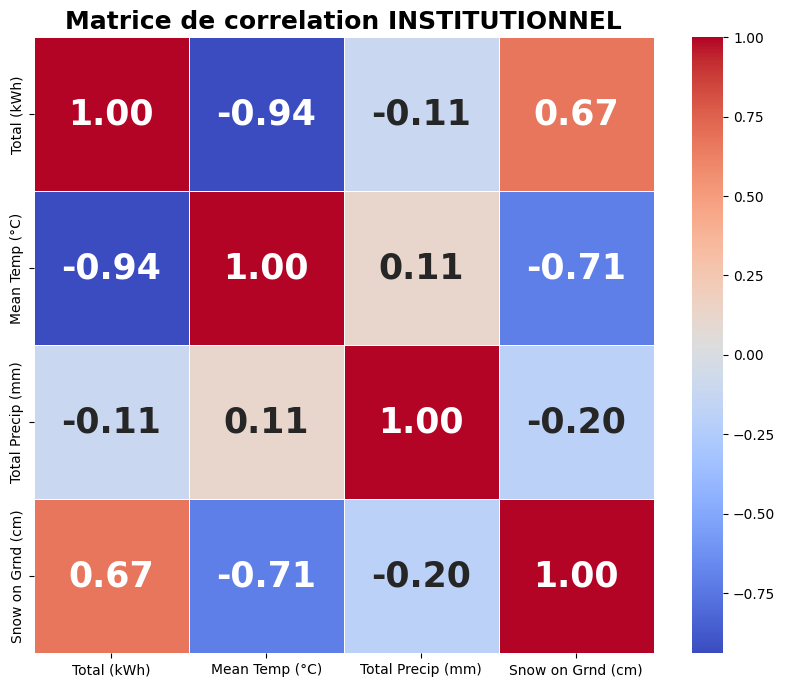

In [18]:
df_without_month = df_INSTITUTIONNEL.drop(columns=['Month', 'ANNEE_MOIS'])

correlation_matrix = df_without_month.corr()

plt.figure(figsize=(10, 8))
annot_kws = {"fontsize": 25, "weight": "bold"}
sns.heatmap(correlation_matrix, annot=True, annot_kws=annot_kws, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title('Matrice de correlation INSTITUTIONNEL', fontsize=18, weight='bold')


plt.show()


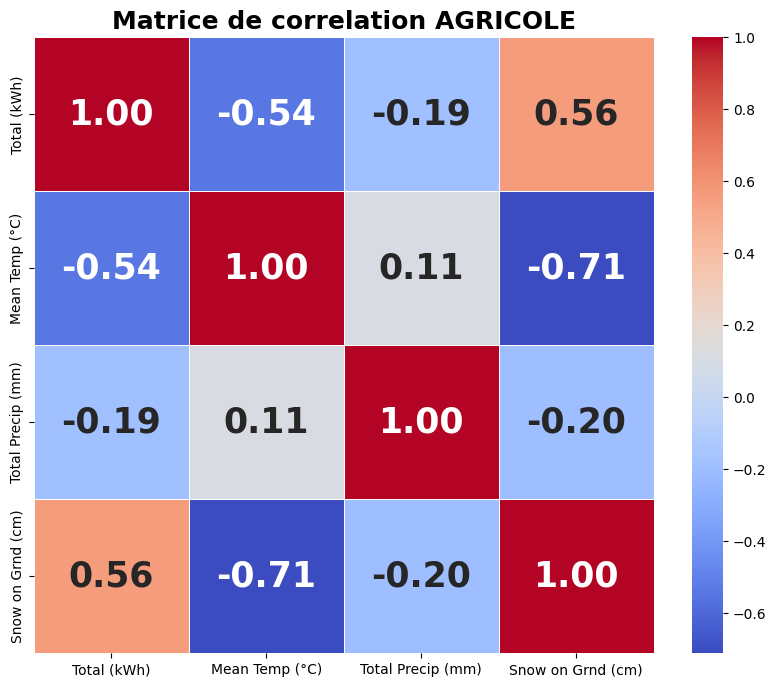

In [19]:
df_without_month = df_AGRICOLE.drop(columns=['Month', 'ANNEE_MOIS'])

correlation_matrix = df_without_month.corr()
plt.figure(figsize=(10, 8))
annot_kws = {"fontsize": 25, "weight": "bold"}
sns.heatmap(correlation_matrix, annot=True, annot_kws=annot_kws, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title('Matrice de correlation AGRICOLE', fontsize=18, weight='bold')


plt.show()

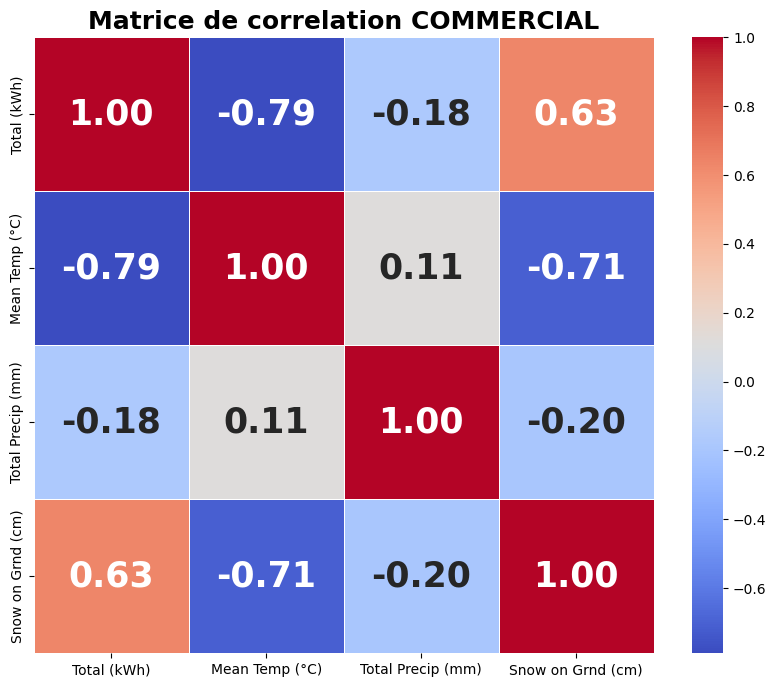

In [20]:
df_without_month = df_COMMERCIAL.drop(columns=['Month', 'ANNEE_MOIS'])

correlation_matrix = df_without_month.corr()
plt.figure(figsize=(10, 8))
annot_kws = {"fontsize": 25, "weight": "bold"}
sns.heatmap(correlation_matrix, annot=True, annot_kws=annot_kws, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title('Matrice de correlation COMMERCIAL', fontsize=18, weight='bold')


plt.show()

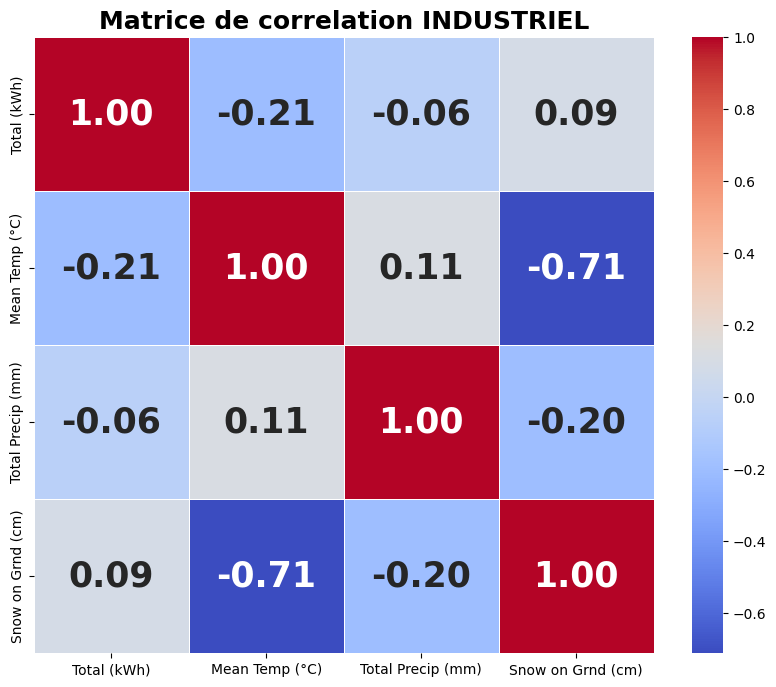

In [21]:
df_without_month = df_INDUSTRIEL.drop(columns=['Month', 'ANNEE_MOIS'])

correlation_matrix = df_without_month.corr()
plt.figure(figsize=(10, 8))

annot_kws = {"fontsize": 25, "weight": "bold"}
sns.heatmap(correlation_matrix, annot=True, annot_kws=annot_kws, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title('Matrice de correlation INDUSTRIEL', fontsize=18, weight='bold')


plt.show()

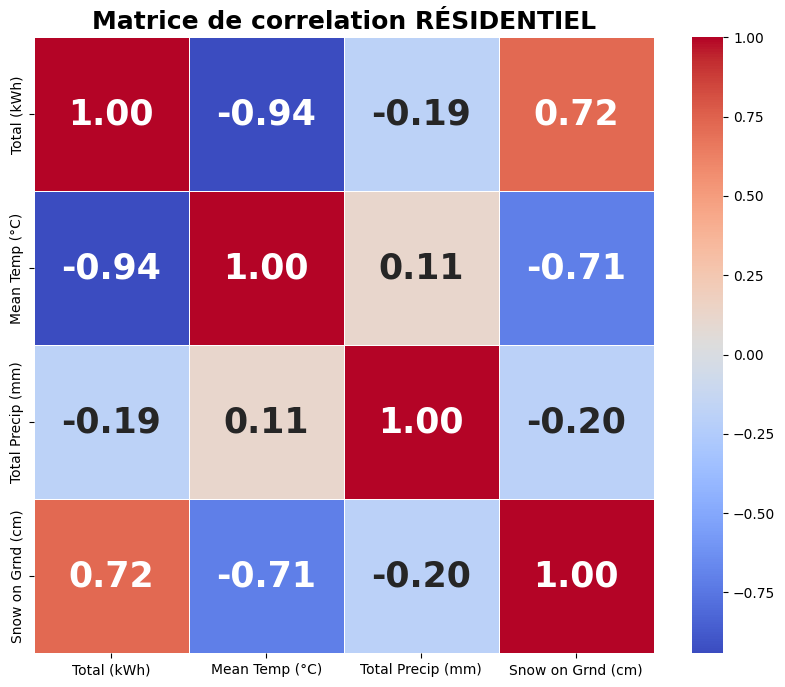

In [22]:
df_without_month = df_RÉSIDENTIEL.drop(columns=['Month', 'ANNEE_MOIS'])

correlation_matrix = df_without_month.corr()
plt.figure(figsize=(10, 8))
annot_kws = {"fontsize": 25, "weight": "bold"}
sns.heatmap(correlation_matrix, annot=True, annot_kws=annot_kws, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title('Matrice de correlation RÉSIDENTIEL', fontsize=18, weight='bold')


plt.show()

Comparaison de la consomation d'électricité

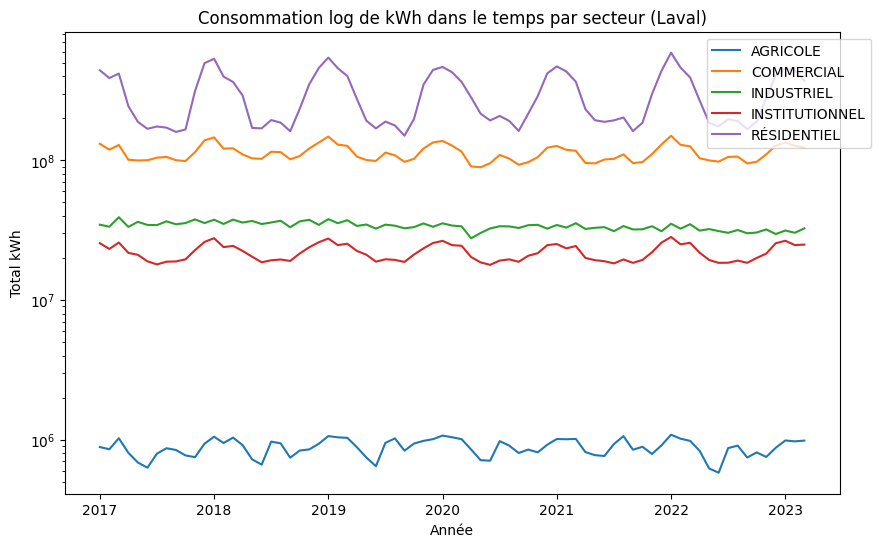

In [23]:
plt.figure(figsize=(10, 6))

plt.plot(df_AGRICOLE['Total (kWh)'], label='AGRICOLE')
plt.plot(df_COMMERCIAL['Total (kWh)'], label='COMMERCIAL')
plt.plot(df_INDUSTRIEL['Total (kWh)'], label='INDUSTRIEL')
plt.plot(df_INSTITUTIONNEL['Total (kWh)'], label='INSTITUTIONNEL')
plt.plot(df_RÉSIDENTIEL['Total (kWh)'], label='RÉSIDENTIEL')

# Set x-axis labels for every 12th data point
x_ticks = range(0, len(df_AGRICOLE), 12)
x_tick_labels = [df_AGRICOLE['ANNEE_MOIS'].iloc[i][:4] for i in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

plt.title('Consommation log de kWh dans le temps par secteur (Laval)')
plt.xlabel('Année')
plt.ylabel('Total kWh')
plt.yscale('log')

plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')

plt.show()

In [24]:
# Import library
import statsmodels.api as sm

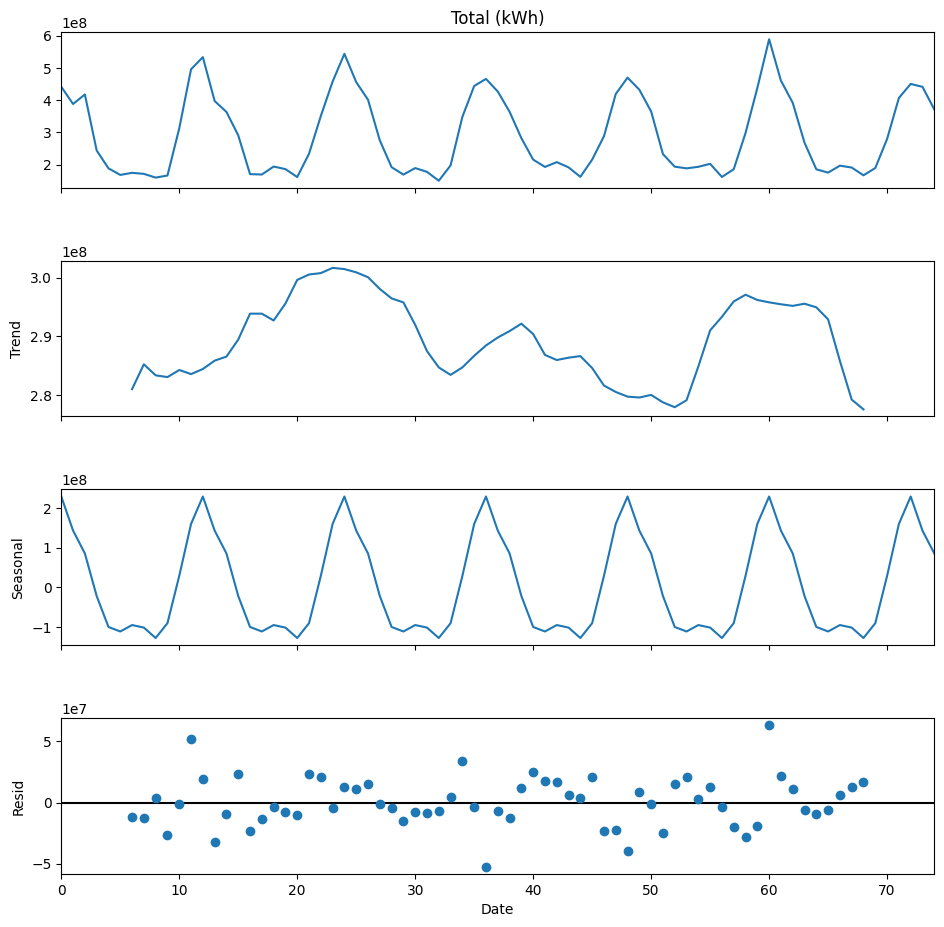

In [25]:
# Decompose data by selecting the appropiate frequency
decomp = sm.tsa.seasonal_decompose(
  df_RÉSIDENTIEL['Total (kWh)'], period=12)
decomp_plot = decomp.plot()

# Plot outcome
plt.xlabel('Date')
decomp_plot .set_figheight(10)
decomp_plot .set_figwidth(10)
plt.show()

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
# Perform seasonal decomposition
decomposed_RÉSIDENTIEL = seasonal_decompose(df_RÉSIDENTIEL['Total (kWh)'], period=12)
decomposed_INSTITUTIONNEL = seasonal_decompose(df_INSTITUTIONNEL['Total (kWh)'], period=12)
decomposed_AGRICOLE = seasonal_decompose(df_AGRICOLE['Total (kWh)'], period=12)
decomposed_COMMERCIAL = seasonal_decompose(df_COMMERCIAL['Total (kWh)'], period=12)
decomposed_INDUSTRIEL = seasonal_decompose(df_INDUSTRIEL['Total (kWh)'], period=12)

seasonal_component_RÉSIDENTIEL = decomposed_RÉSIDENTIEL.seasonal
seasonal_component_INSTITUTIONNEL = decomposed_INSTITUTIONNEL.seasonal
seasonal_component_AGRICOLE = decomposed_AGRICOLE.seasonal
seasonal_component_COMMERCIAL = decomposed_COMMERCIAL.seasonal
seasonal_component_INDUSTRIEL = decomposed_INDUSTRIEL.seasonal

# Calculate the residual (resid + trend) for each category
residual_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'] - seasonal_component_RÉSIDENTIEL
residual_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'] - seasonal_component_INSTITUTIONNEL
residual_AGRICOLE = df_AGRICOLE['Total (kWh)'] - seasonal_component_AGRICOLE
residual_COMMERCIAL = df_COMMERCIAL['Total (kWh)'] - seasonal_component_COMMERCIAL
residual_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'] - seasonal_component_INDUSTRIEL

In [29]:
df_RÉSIDENTIEL['Seasonality'] = seasonal_component_RÉSIDENTIEL
df_INSTITUTIONNEL['Seasonality'] = seasonal_component_INSTITUTIONNEL
df_AGRICOLE['Seasonality'] = seasonal_component_AGRICOLE
df_COMMERCIAL['Seasonality'] = seasonal_component_COMMERCIAL
df_INDUSTRIEL['Seasonality'] = seasonal_component_INDUSTRIEL

In [31]:
df_RÉSIDENTIEL['Residual'] = residual_RÉSIDENTIEL
df_INSTITUTIONNEL['Residual'] = residual_INSTITUTIONNEL
df_AGRICOLE['Residual'] = residual_AGRICOLE
df_COMMERCIAL['Residual'] = residual_COMMERCIAL
df_INDUSTRIEL['Residual'] = residual_INDUSTRIEL

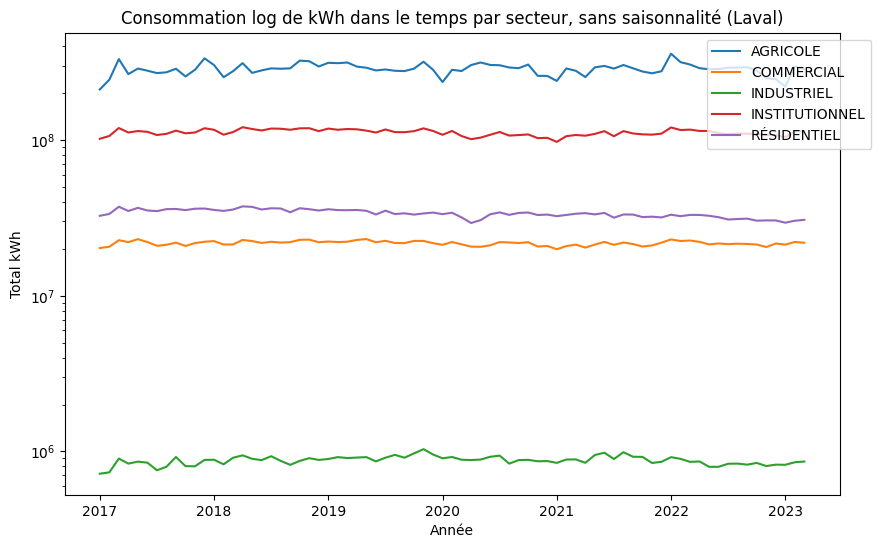

In [32]:
plt.figure(figsize=(10, 6))

plt.plot(residual_RÉSIDENTIEL, label='AGRICOLE')
plt.plot(residual_INSTITUTIONNEL, label='COMMERCIAL')
plt.plot(residual_AGRICOLE, label='INDUSTRIEL')
plt.plot(residual_COMMERCIAL, label='INSTITUTIONNEL')
plt.plot(residual_INDUSTRIEL, label='RÉSIDENTIEL')

# Set x-axis labels for every 12th data point
x_ticks = range(0, len(df_AGRICOLE), 12)
x_tick_labels = [df_AGRICOLE['ANNEE_MOIS'].iloc[i][:4] for i in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

plt.title('Consommation log de kWh dans le temps par secteur, sans saisonnalité (Laval)')
plt.xlabel('Année')
plt.ylabel('Total kWh')
plt.yscale('log')

plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')

plt.show()

In [33]:

# Calculate the new statistics about the deseasonalized data
mean_INSTITUTIONNEL = residual_INSTITUTIONNEL.mean()
median_INSTITUTIONNEL = "{:,.2f}".format(residual_INSTITUTIONNEL.median())
std_INSTITUTIONNEL = residual_INSTITUTIONNEL.std()
min_INSTITUTIONNEL = residual_INSTITUTIONNEL.min()
max_INSTITUTIONNEL = residual_INSTITUTIONNEL.max()

mean_AGRICOLE = residual_AGRICOLE.mean()
median_AGRICOLE = "{:,.2f}".format(residual_AGRICOLE.median())
std_AGRICOLE = residual_AGRICOLE.std()
min_AGRICOLE = residual_AGRICOLE.min()
max_AGRICOLE = residual_AGRICOLE.max()

mean_COMMERCIAL = residual_COMMERCIAL.mean()
median_COMMERCIAL = "{:,.2f}".format(residual_COMMERCIAL.median())
std_COMMERCIAL = residual_COMMERCIAL.std()
min_COMMERCIAL = residual_COMMERCIAL.min()
max_COMMERCIAL = residual_COMMERCIAL.max()

mean_INDUSTRIEL = residual_INDUSTRIEL.mean()
median_INDUSTRIEL = "{:,.2f}".format(residual_INDUSTRIEL.median())
std_INDUSTRIEL = residual_INDUSTRIEL.std()
min_INDUSTRIEL = residual_INDUSTRIEL.min()
max_INDUSTRIEL = residual_INDUSTRIEL.max()

mean_RÉSIDENTIEL = residual_RÉSIDENTIEL.mean()
median_RÉSIDENTIEL = "{:,.2f}".format(residual_RÉSIDENTIEL.median())
std_RÉSIDENTIEL = residual_RÉSIDENTIEL.std()
min_RÉSIDENTIEL = residual_RÉSIDENTIEL.min()
max_RÉSIDENTIEL = residual_RÉSIDENTIEL.max()

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INSTITUTIONNEL :',mean_INSTITUTIONNEL, median_INSTITUTIONNEL, std_INSTITUTIONNEL)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_AGRICOLE :', mean_AGRICOLE, median_AGRICOLE, std_AGRICOLE)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_COMMERCIAL :', mean_COMMERCIAL, median_COMMERCIAL, std_COMMERCIAL)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INDUSTRIEL :', mean_INDUSTRIEL, median_INDUSTRIEL, std_INDUSTRIEL)

print('Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_Residentiel :',mean_RÉSIDENTIEL, median_RÉSIDENTIEL, std_RÉSIDENTIEL)


Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INSTITUTIONNEL : 21763881.082889356 21,849,610.96 727953.2435599283
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_AGRICOLE : 875604.6292222221 880,879.01 56357.91452888703
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_COMMERCIAL : 111919587.92808427 112,458,953.07 5147035.694427404
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_INDUSTRIEL : 33783977.57643453 33,652,615.48 1998593.1794319013
Moyenne, Médianne et Écart-type sur la période de la consommation de kWh pour df_Residentiel : 286254534.639912 287,979,901.44 25272413.970902104


In [34]:
# Perform seasonal decomposition
decomposed_temp = seasonal_decompose(df_RÉSIDENTIEL['Mean Temp (°C)'], period=12)
decomposed_precip = seasonal_decompose(df_RÉSIDENTIEL['Total Precip (mm)'], period=12)
decomposed_snow = seasonal_decompose(df_RÉSIDENTIEL['Snow on Grnd (cm)'], period=12)


seasonal_component_temp = decomposed_temp.seasonal
seasonal_component_precip = decomposed_precip.seasonal
seasonal_component_snow = decomposed_snow.seasonal


# Calculate the residual for each category
residual_temp = df_RÉSIDENTIEL['Mean Temp (°C)'] - seasonal_component_temp
residual_precip = df_RÉSIDENTIEL['Total Precip (mm)'] - seasonal_component_precip
residual_snow = df_RÉSIDENTIEL['Snow on Grnd (cm)'] - seasonal_component_snow


In [35]:
df_RÉSIDENTIEL['Residual Mean Temp (°C)'] = residual_temp
df_RÉSIDENTIEL['Residual Total Precip (mm)'] = residual_precip
df_RÉSIDENTIEL['Residual Snow on Grnd (cm)'] = residual_snow


df_INSTITUTIONNEL['Residual Mean Temp (°C)'] = residual_temp
df_INSTITUTIONNEL['Residual Total Precip (mm)'] = residual_precip
df_INSTITUTIONNEL['Residual Snow on Grnd (cm)'] = residual_snow

df_AGRICOLE['Residual Mean Temp (°C)'] = residual_temp
df_AGRICOLE['Residual Total Precip (mm)'] = residual_precip
df_AGRICOLE['Residual Snow on Grnd (cm)'] = residual_snow


df_COMMERCIAL['Residual Mean Temp (°C)'] = residual_temp
df_COMMERCIAL['Residual Total Precip (mm)'] = residual_precip
df_COMMERCIAL['Residual Snow on Grnd (cm)'] = residual_snow

df_INDUSTRIEL['Residual Mean Temp (°C)'] = residual_temp
df_INDUSTRIEL['Residual Total Precip (mm)'] = residual_precip
df_INDUSTRIEL['Residual Snow on Grnd (cm)'] = residual_snow

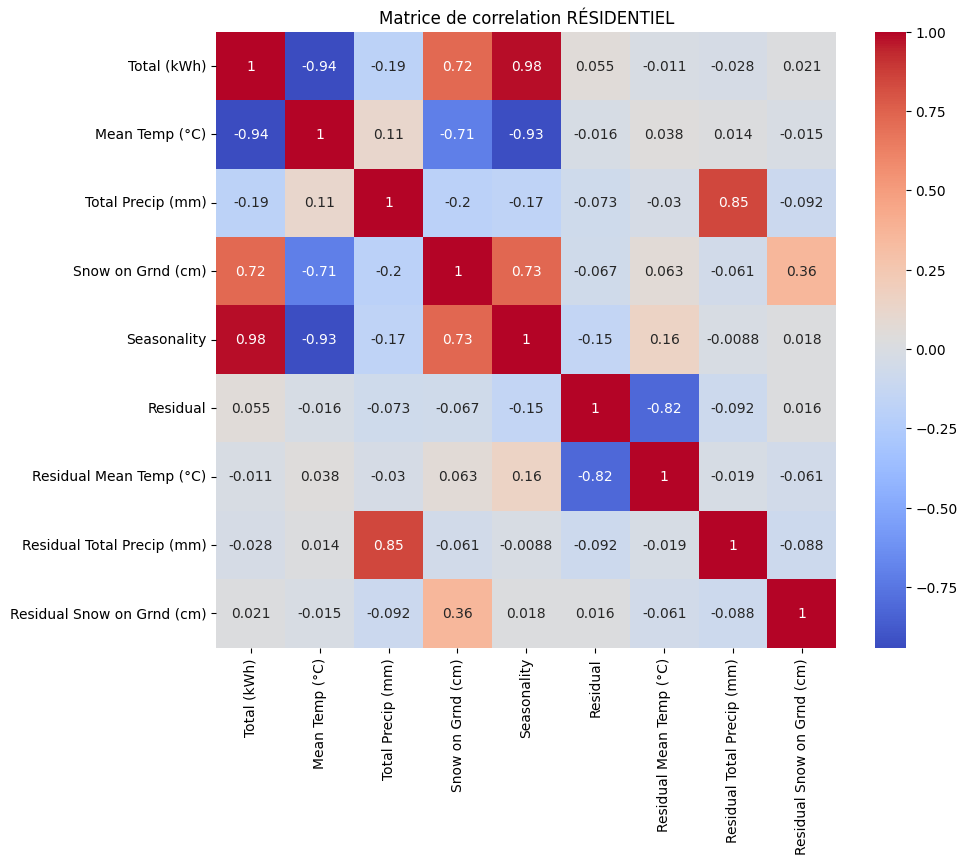

In [37]:
df_without_month = df_RÉSIDENTIEL.drop(columns=['Month', 'ANNEE_MOIS'])

correlation_matrix = df_without_month.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


plt.title('Matrice de correlation RÉSIDENTIEL')


plt.show()

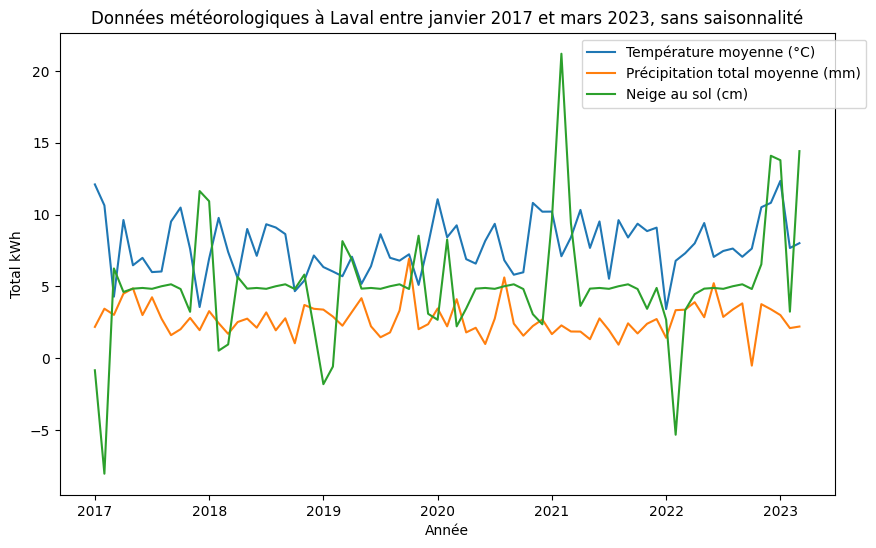

In [38]:
plt.figure(figsize=(10, 6))

plt.plot(residual_temp, label='Température moyenne (°C)')
plt.plot(residual_precip, label='Précipitation total moyenne (mm)')
plt.plot(residual_snow, label='Neige au sol (cm)')

# Set x-axis labels for every 12th data point
x_ticks = range(0, len(df_AGRICOLE), 12)
x_tick_labels = [df_AGRICOLE['ANNEE_MOIS'].iloc[i][:4] for i in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

plt.title('Données météorologiques à Laval entre janvier 2017 et mars 2023, sans saisonnalité')
plt.xlabel('Année')
plt.ylabel('Total kWh')

plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')

plt.show()

In [40]:
# Again the new stats
mean_temp = residual_temp.mean()
median_temp = "{:,.2f}".format(residual_temp.median())
std_temp = residual_temp.std()
min_temp = residual_temp.min()
max_temp = residual_temp.max()

mean_precip = residual_precip.mean()
median_precip = "{:,.2f}".format(residual_precip.median())
std_precip = residual_precip.std()
min_precip = residual_precip.min()
max_precip = residual_precip.max()

mean_snow = residual_snow.mean()
median_snow = "{:,.2f}".format(residual_snow.median())
std_snow = residual_snow.std()
min_snow = residual_snow.min()
max_snow = residual_snow.max()

In [41]:
print(mean_temp, median_temp, std_temp, min_temp, max_temp)
print(mean_precip, median_precip, std_precip, min_precip, max_precip)
print(mean_snow, median_snow, std_snow, min_snow, max_snow)

7.836786656977771 7.64 1.921403011309728 3.4256623487811293 12.35146880039403
2.7158330307697036 2.70 1.139936907929095 -0.5125593410013995 6.934322379428707
5.014093496642186 4.85 3.9522676955481444 -8.042220512413937 21.207779487586063


### **Modélisation**






In [43]:
# reinitiate the stats to their original data to perform the normalization on RMSE/MAE
mean_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].mean()
median_INSTITUTIONNEL = "{:,.2f}".format(df_INSTITUTIONNEL['Total (kWh)'].median())
std_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].std()
min_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].min()
max_INSTITUTIONNEL = df_INSTITUTIONNEL['Total (kWh)'].max()

mean_AGRICOLE = df_AGRICOLE['Total (kWh)'].mean()
median_AGRICOLE = "{:,.2f}".format(df_AGRICOLE['Total (kWh)'].median())
std_AGRICOLE = df_AGRICOLE['Total (kWh)'].std()
min_AGRICOLE = df_AGRICOLE['Total (kWh)'].min()
max_AGRICOLE = df_AGRICOLE['Total (kWh)'].max()

mean_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].mean()
median_COMMERCIAL = "{:,.2f}".format(df_COMMERCIAL['Total (kWh)'].median())
std_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].std()
min_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].min()
max_COMMERCIAL = df_COMMERCIAL['Total (kWh)'].max()

mean_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].mean()
median_INDUSTRIEL = "{:,.2f}".format(df_INDUSTRIEL['Total (kWh)'].median())
std_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].std()
min_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].min()
max_INDUSTRIEL = df_INDUSTRIEL['Total (kWh)'].max()

mean_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].mean()
median_RÉSIDENTIEL = "{:,.2f}".format(df_RÉSIDENTIEL['Total (kWh)'].median())
std_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].std()
min_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].min()
max_RÉSIDENTIEL = df_RÉSIDENTIEL['Total (kWh)'].max()


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

AGRICOLE

R² score on test set: 0.487160353789062
Root Mean Squared Error Normalized: 0.10239944265798681
Mean Absolute Error Normalized: 0.08462169464363449


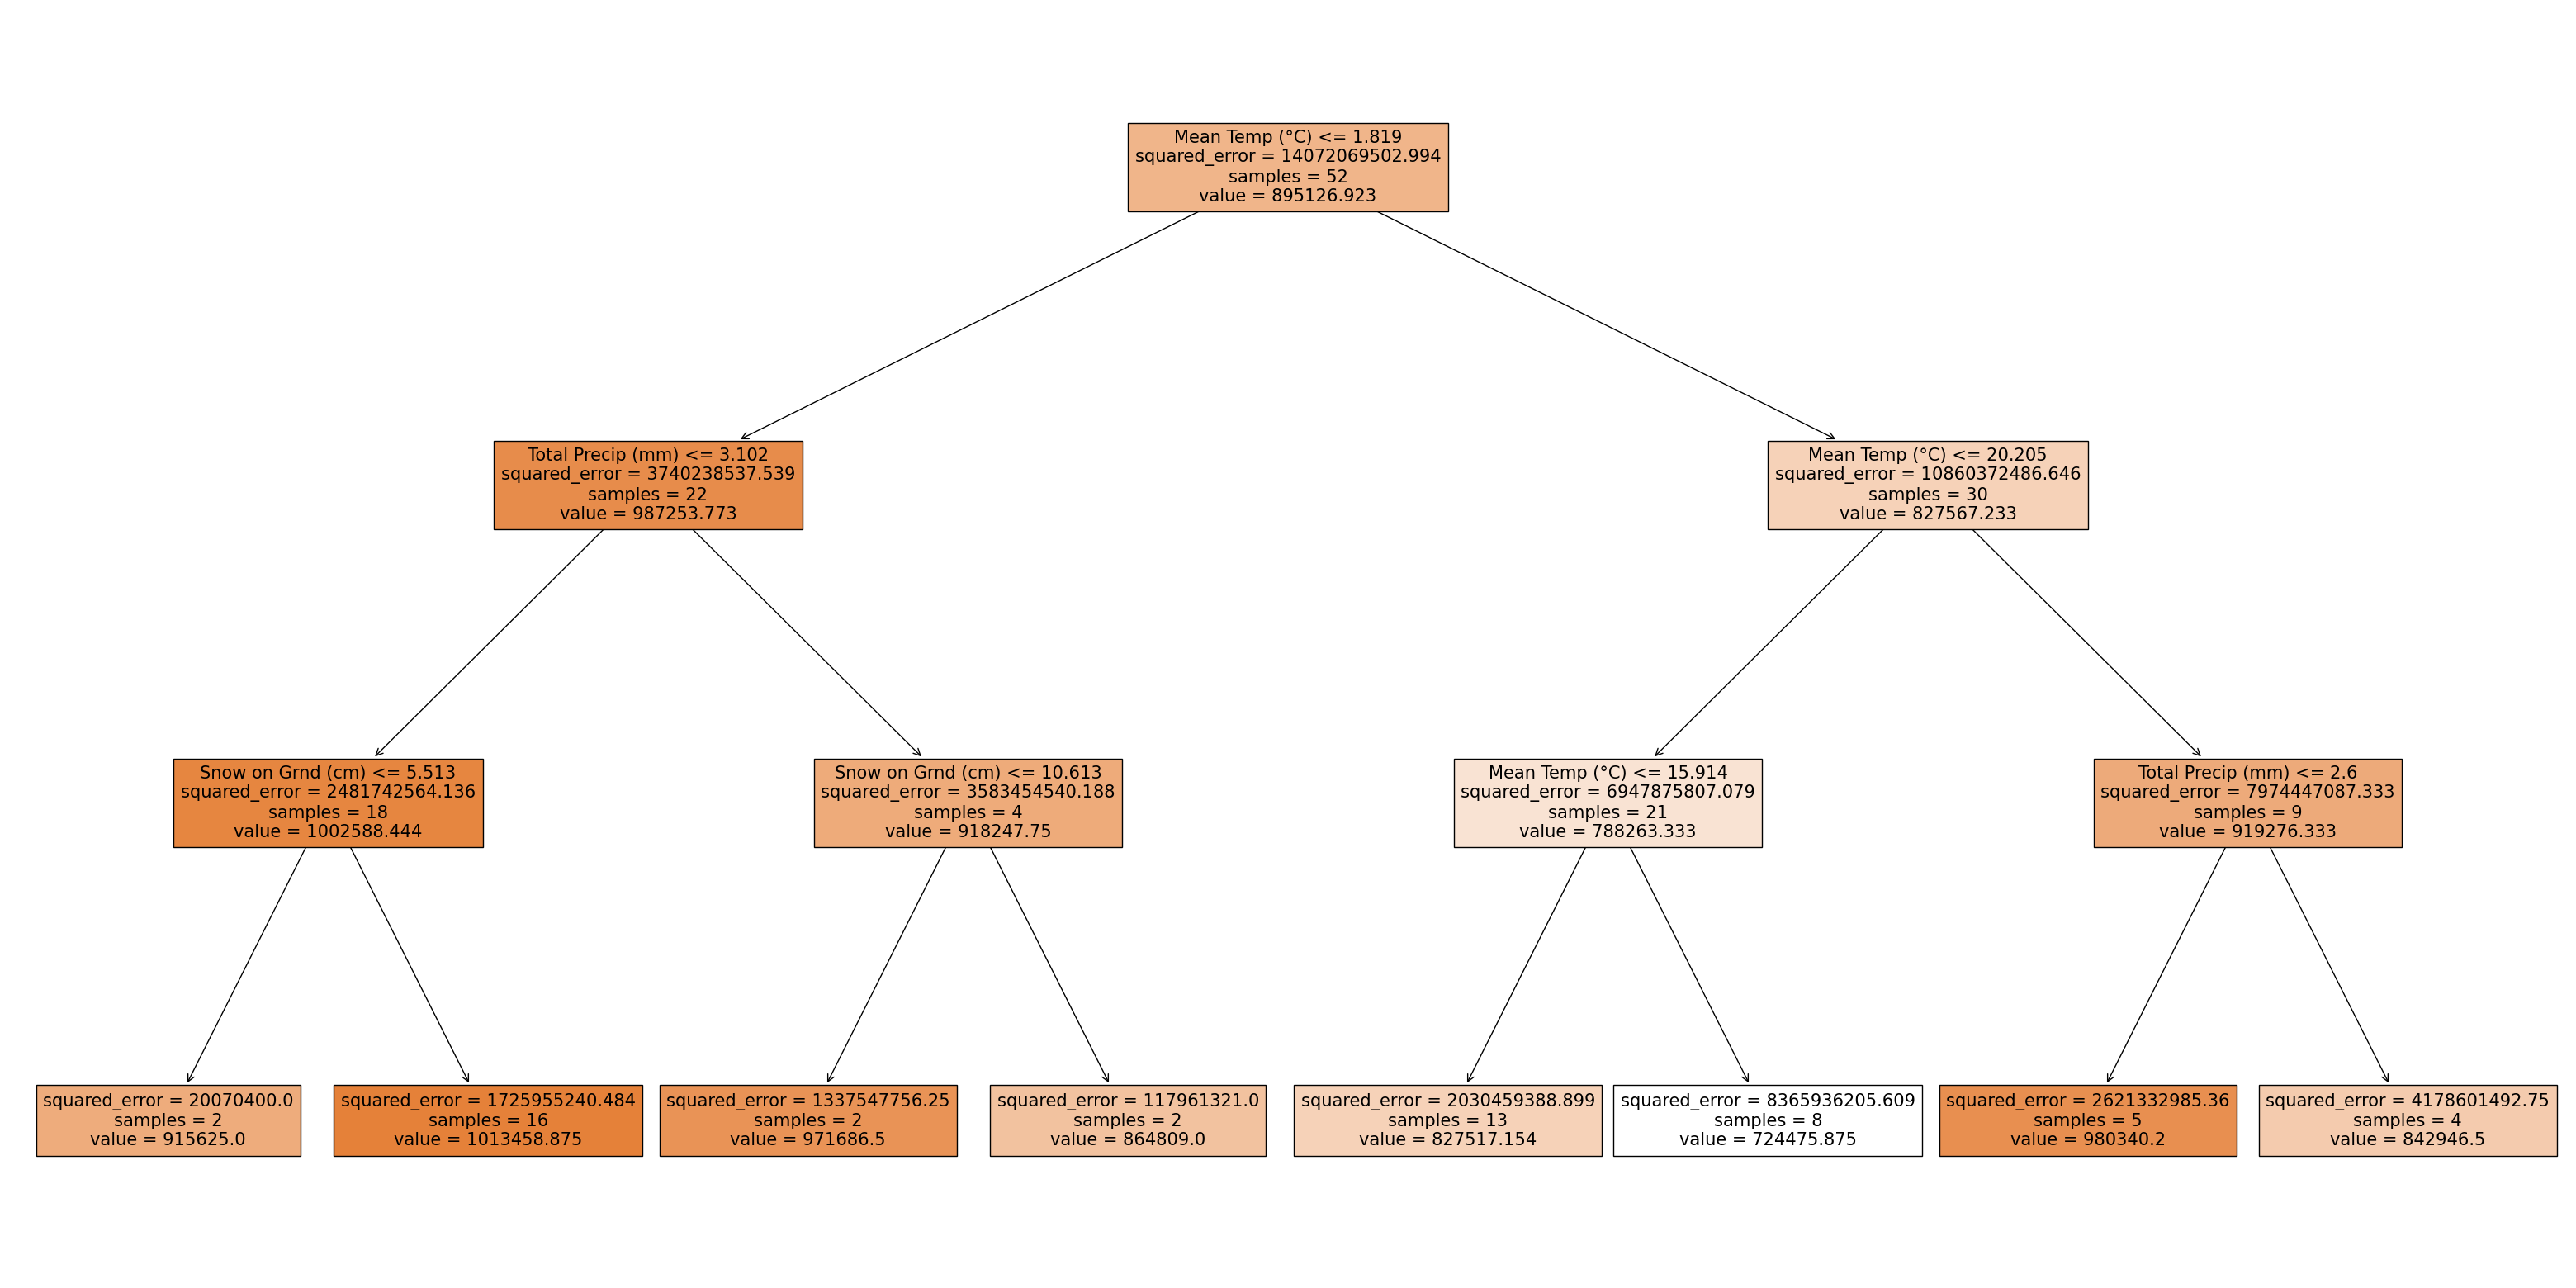

In [45]:
X = df_AGRICOLE[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_AGRICOLE['Total (kWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_AGRICOLE = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_AGRICOLE_normalized = rmse_AGRICOLE/mean_AGRICOLE
print("Root Mean Squared Error Normalized:", rmse_AGRICOLE_normalized)

mae_AGRICOLE = mean_absolute_error(y_test, y_pred)
mae_AGRICOLE_normalized = mae_AGRICOLE / mean_AGRICOLE
print("Mean Absolute Error Normalized:", mae_AGRICOLE_normalized)


plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()



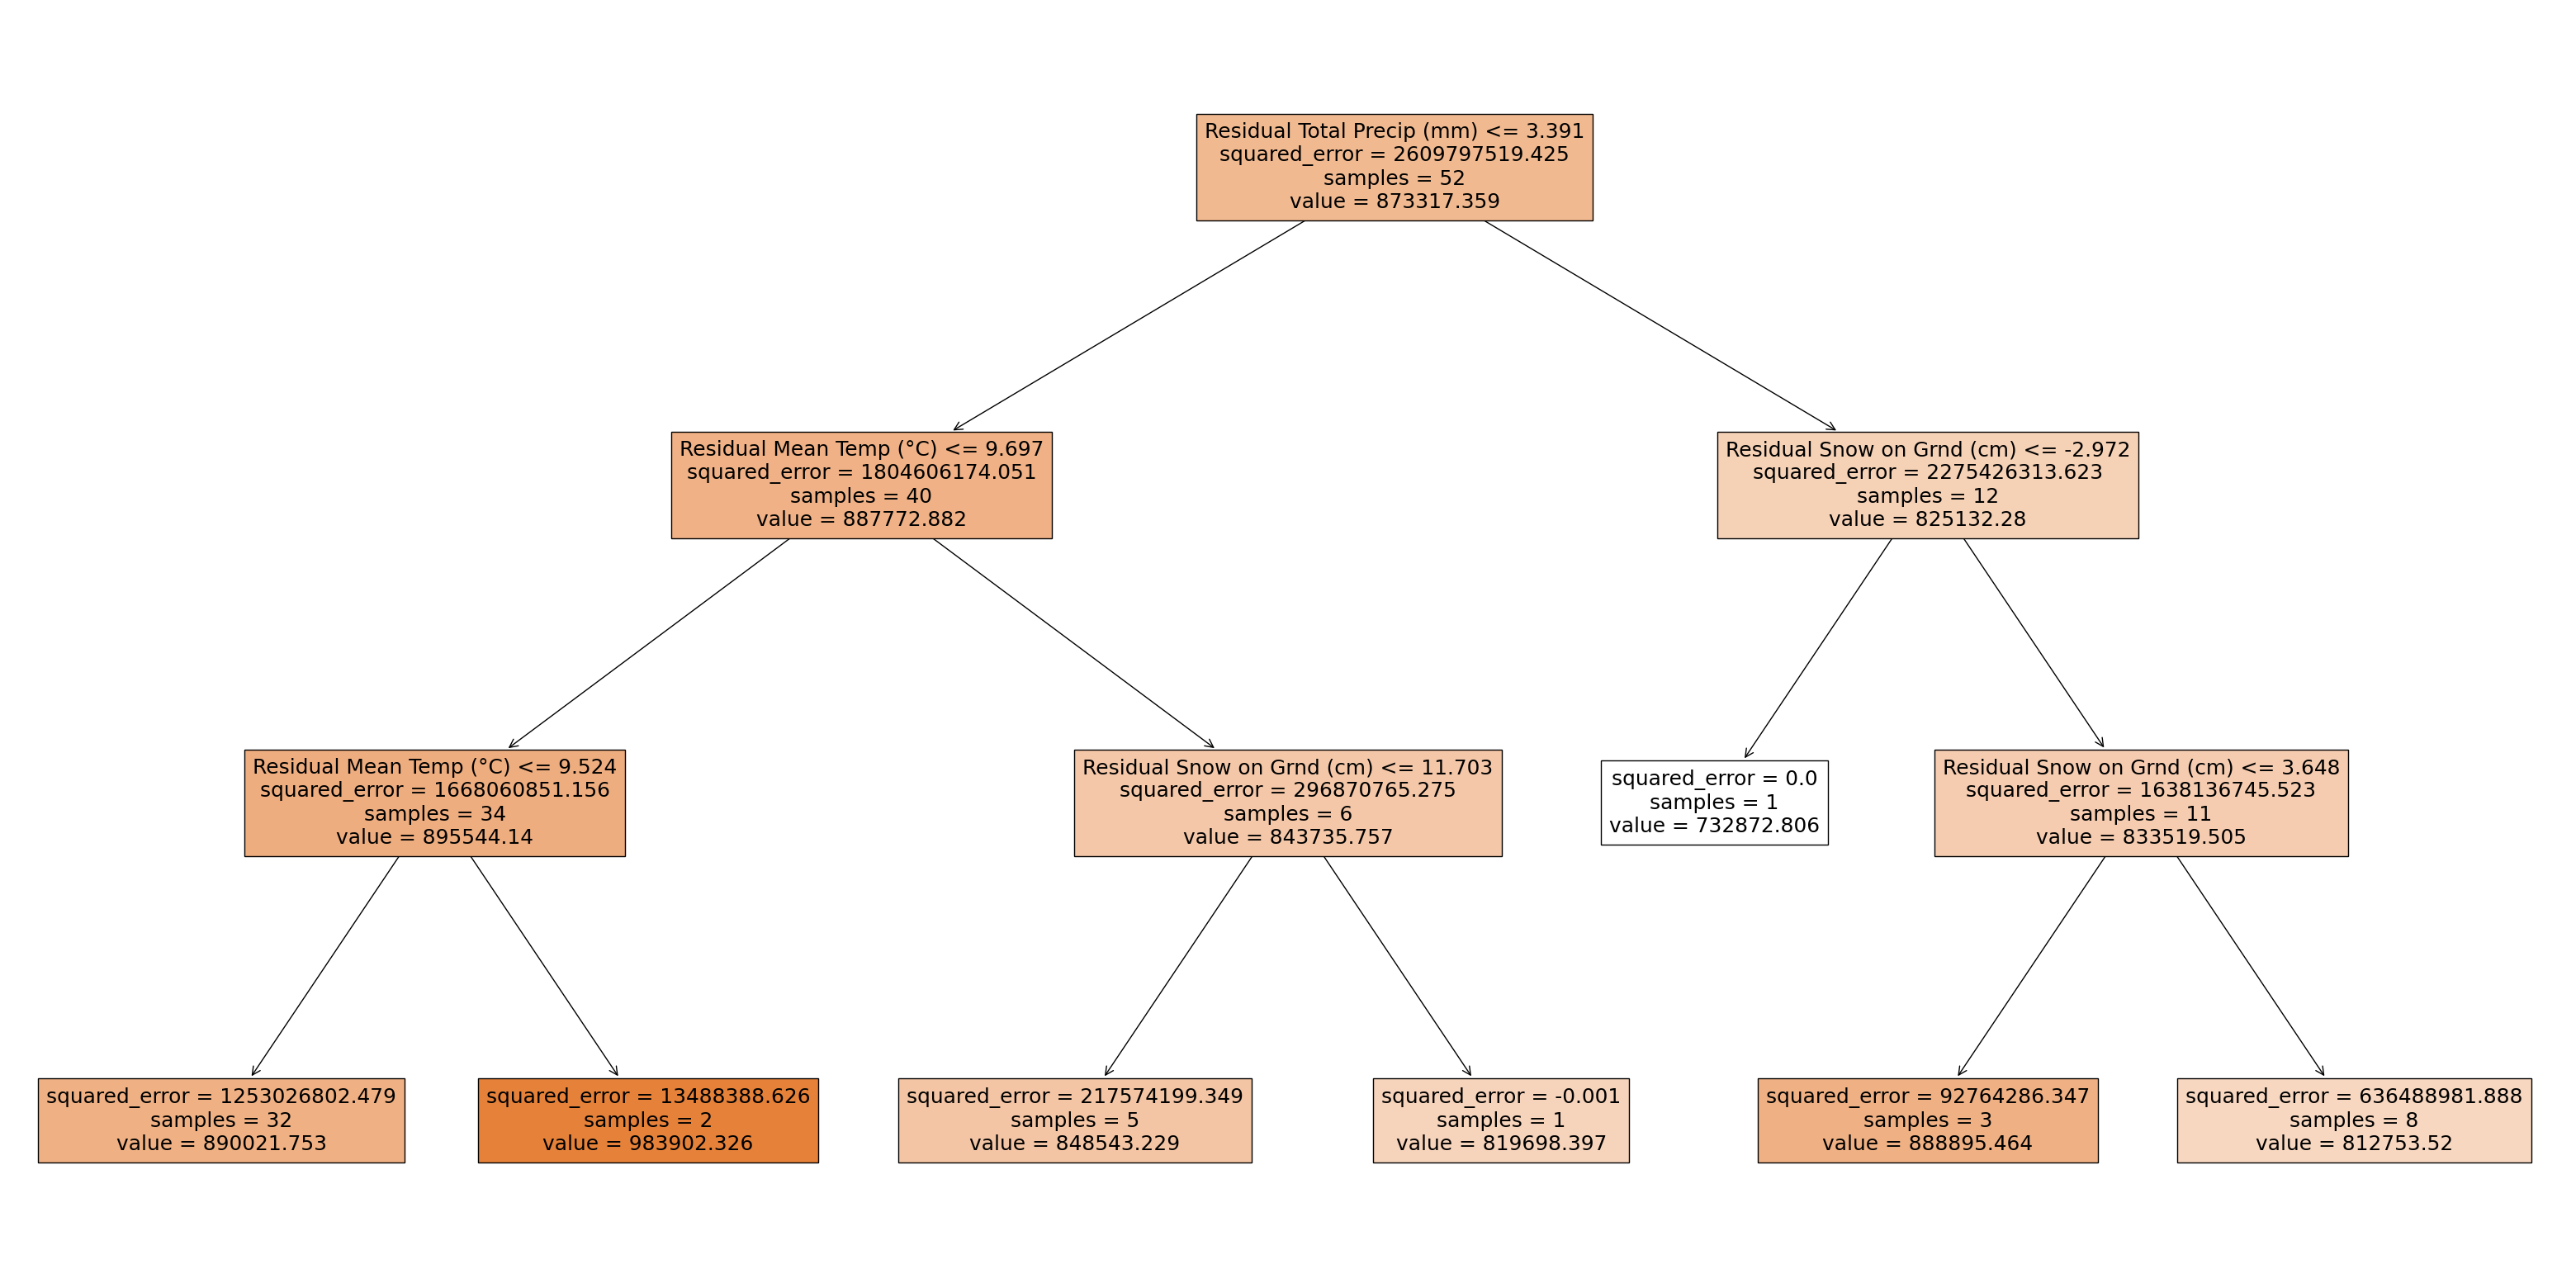

In [46]:
X = df_AGRICOLE[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_AGRICOLE['Residual']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()

In [47]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_RÉSIDENTIEL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_RÉSIDENTIEL['Residual']
    match_index = df_AGRICOLE.index[df_AGRICOLE['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_AGRICOLE.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_AGRICOLE = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_AGRICOLE_normalized = rmse_AGRICOLE/mean_AGRICOLE
print("Root Mean Squared Error Normalized:", rmse_AGRICOLE_normalized)

mae_AGRICOLE = mean_absolute_error(y_test, y_pred)
mae_AGRICOLE_normalized = mae_AGRICOLE / mean_AGRICOLE
print("Mean Absolute Error Normalized:", mae_AGRICOLE_normalized)

R² score on test set: 0.6660151210652737
Root Mean Squared Error Normalized: 0.08263617358601542
Mean Absolute Error Normalized: 0.06524835751945172



INSTITUTIONNEL


R² score on test set: 0.7920053540712209
Root Mean Squared Error Normalized: 0.05425226372877227
Mean Absolute Error Normalized: 0.038861907016042856


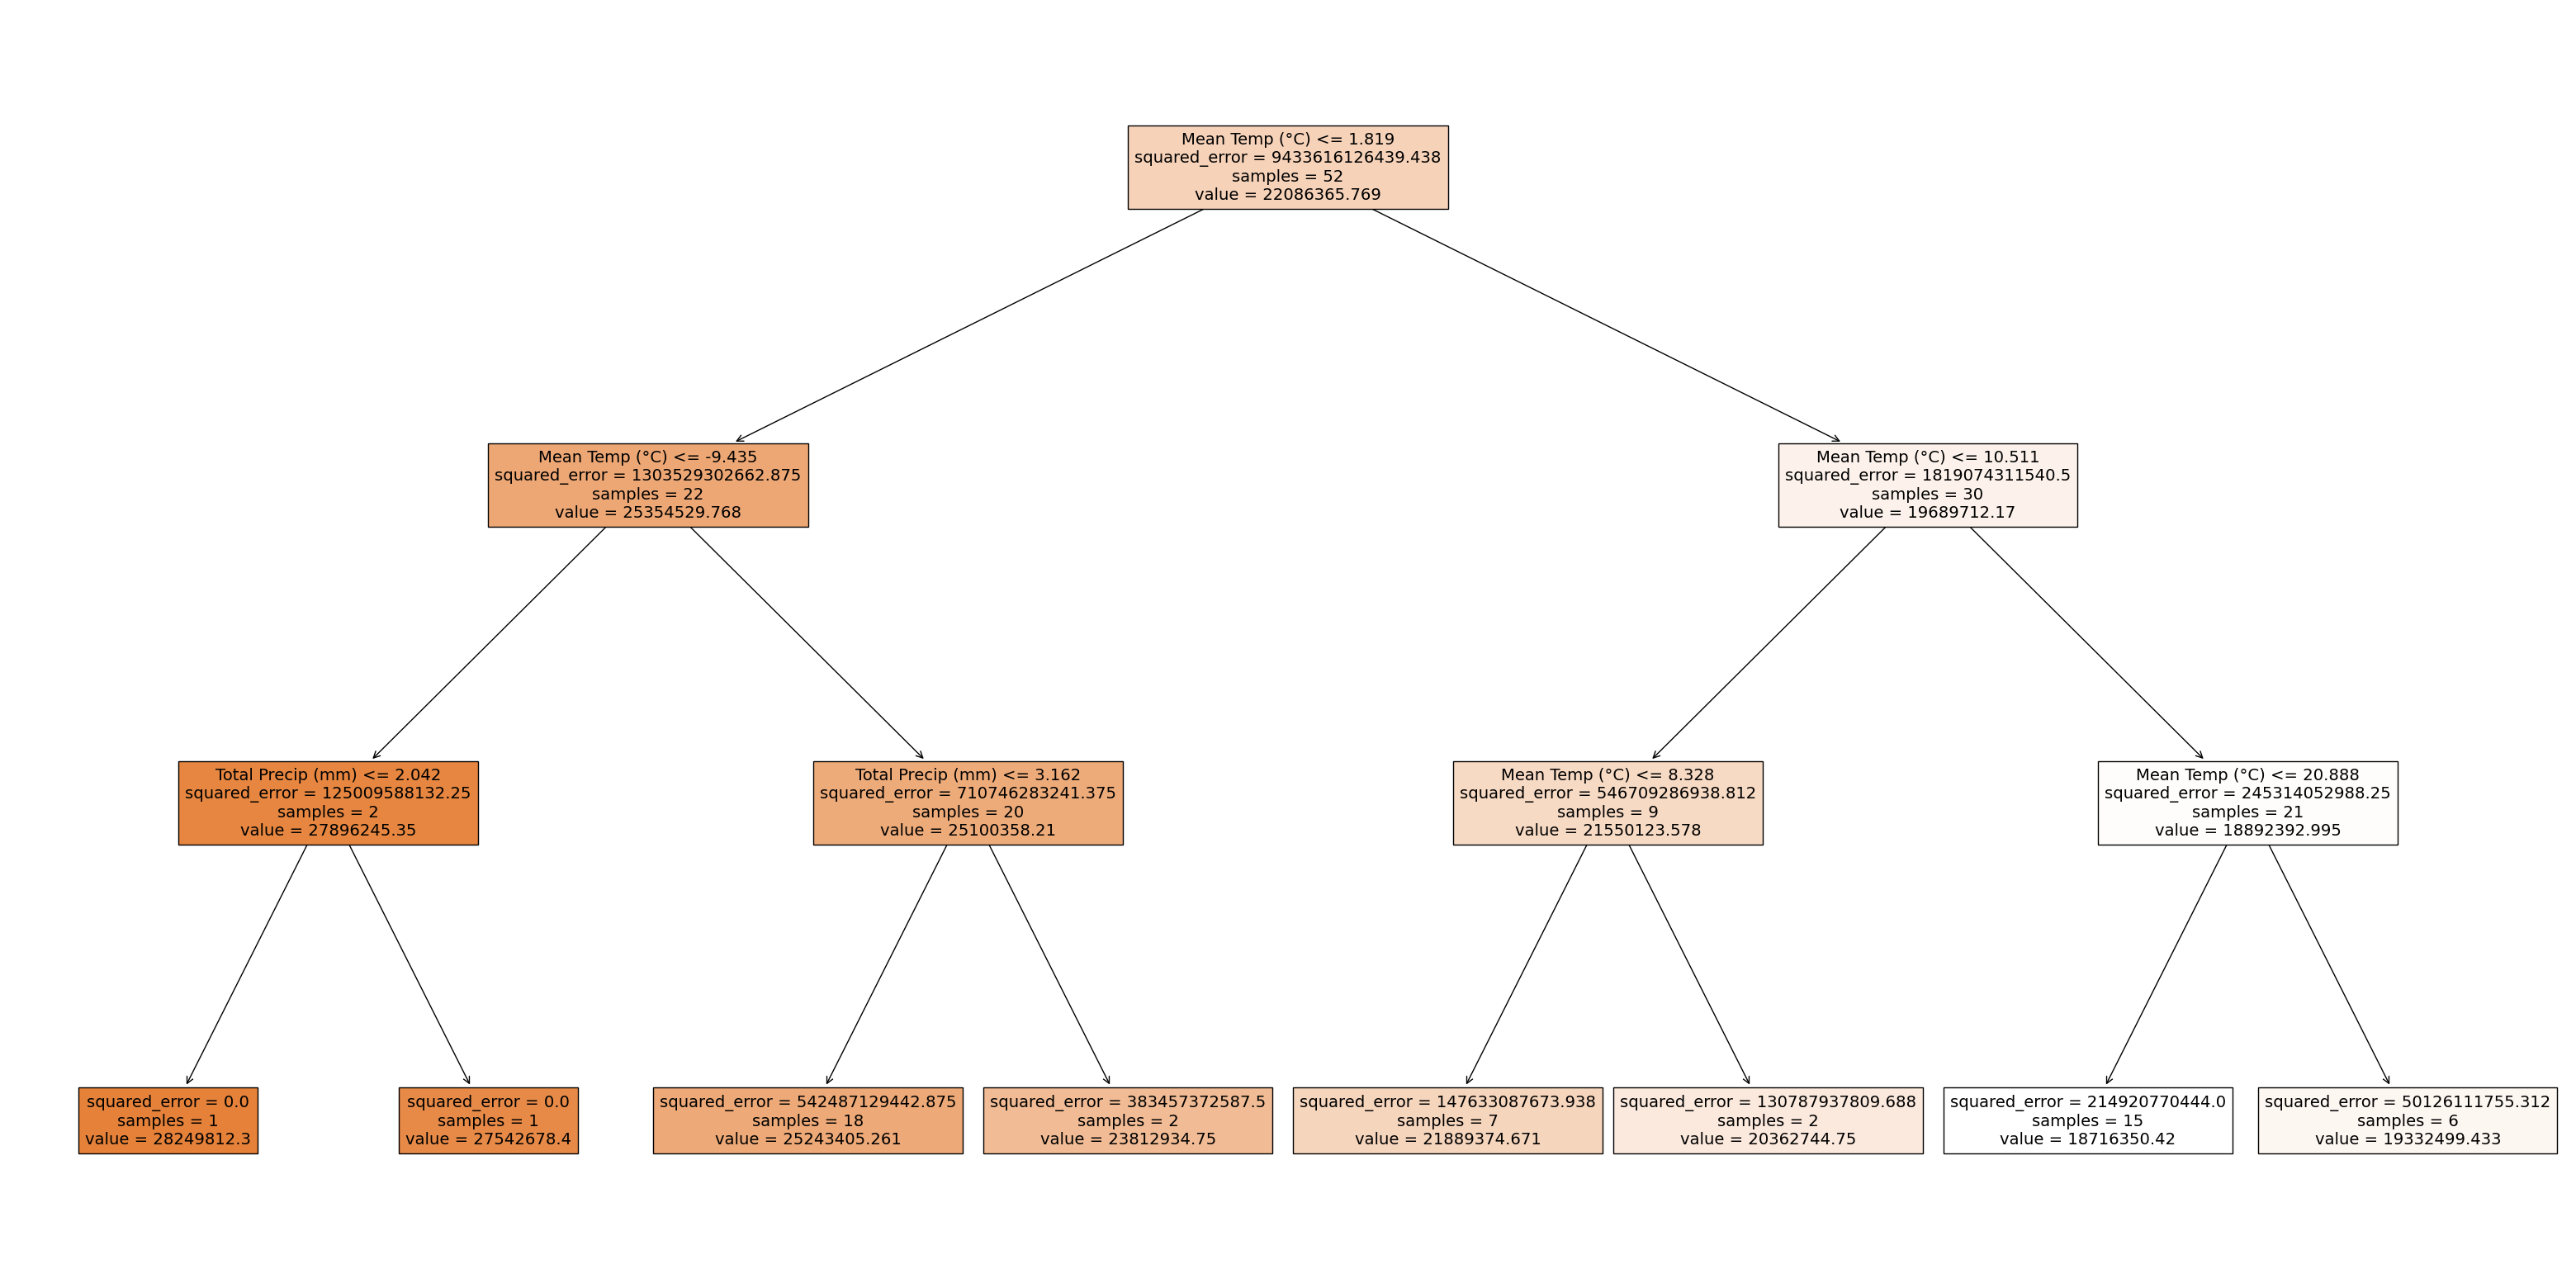

In [48]:
X = df_INSTITUTIONNEL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_INSTITUTIONNEL['Total (kWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_INSTITUTIONNEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INSTITUTIONNEL_normalized = rmse_INSTITUTIONNEL/mean_INSTITUTIONNEL
print("Root Mean Squared Error Normalized:", rmse_INSTITUTIONNEL_normalized)

mae_INSTITUTIONNEL = mean_absolute_error(y_test, y_pred)
mae_INSTITUTIONNEL_normalized = mae_INSTITUTIONNEL / mean_INSTITUTIONNEL
print("Mean Absolute Error Normalized:", mae_INSTITUTIONNEL_normalized)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()

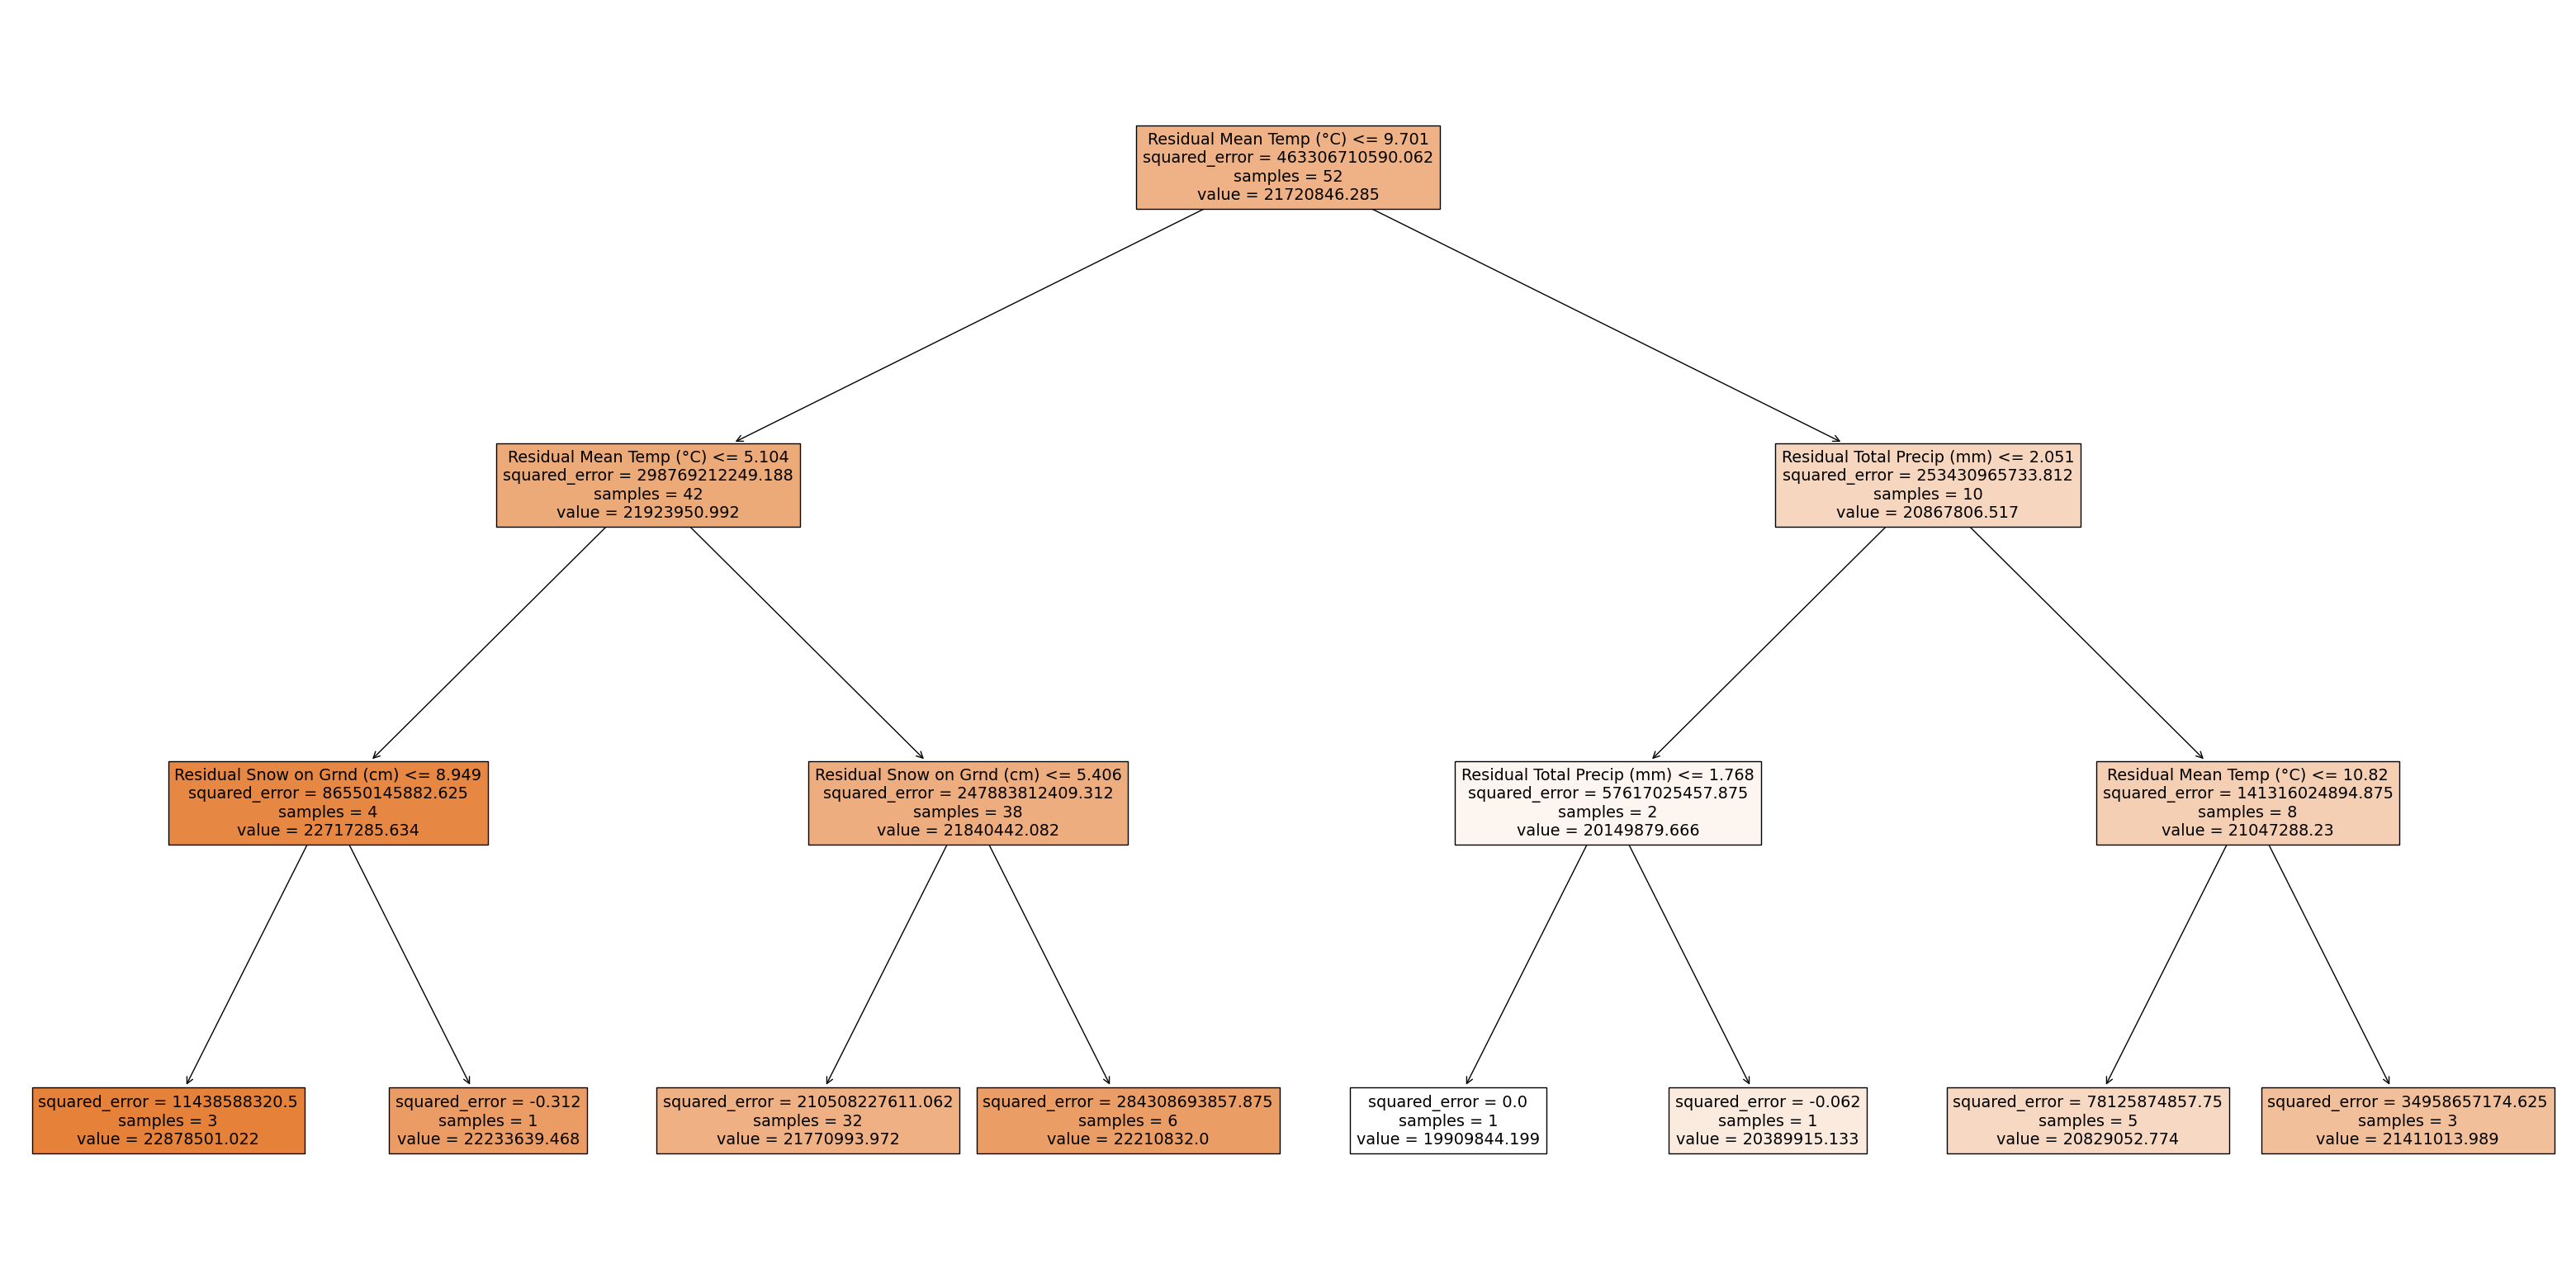

In [49]:
X = df_INSTITUTIONNEL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_INSTITUTIONNEL['Residual']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()

In [50]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_INSTITUTIONNEL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_INSTITUTIONNEL['Residual']
    match_index = df_INSTITUTIONNEL.index[df_INSTITUTIONNEL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_INSTITUTIONNEL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_INSTITUTIONNEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INSTITUTIONNEL_normalized = rmse_INSTITUTIONNEL / mean_INSTITUTIONNEL
print("Root Mean Squared Error Normalized:", rmse_INSTITUTIONNEL_normalized)

mae_INSTITUTIONNEL = mean_absolute_error(y_test, y_pred)
mae_INSTITUTIONNEL_normalized = mae_INSTITUTIONNEL / mean_INSTITUTIONNEL
print("Mean Absolute Error Normalized:", mae_INSTITUTIONNEL_normalized)

R² score on test set: 0.9176957106438733
Root Mean Squared Error Normalized: 0.0341273857238133
Mean Absolute Error Normalized: 0.02849077922523901


COMMERCIAL

R² score on test set: 0.8512079041336343
Root Mean Squared Error Normalized: 0.05020774180662685
Mean Absolute Error Normalized: 0.037097966039019395


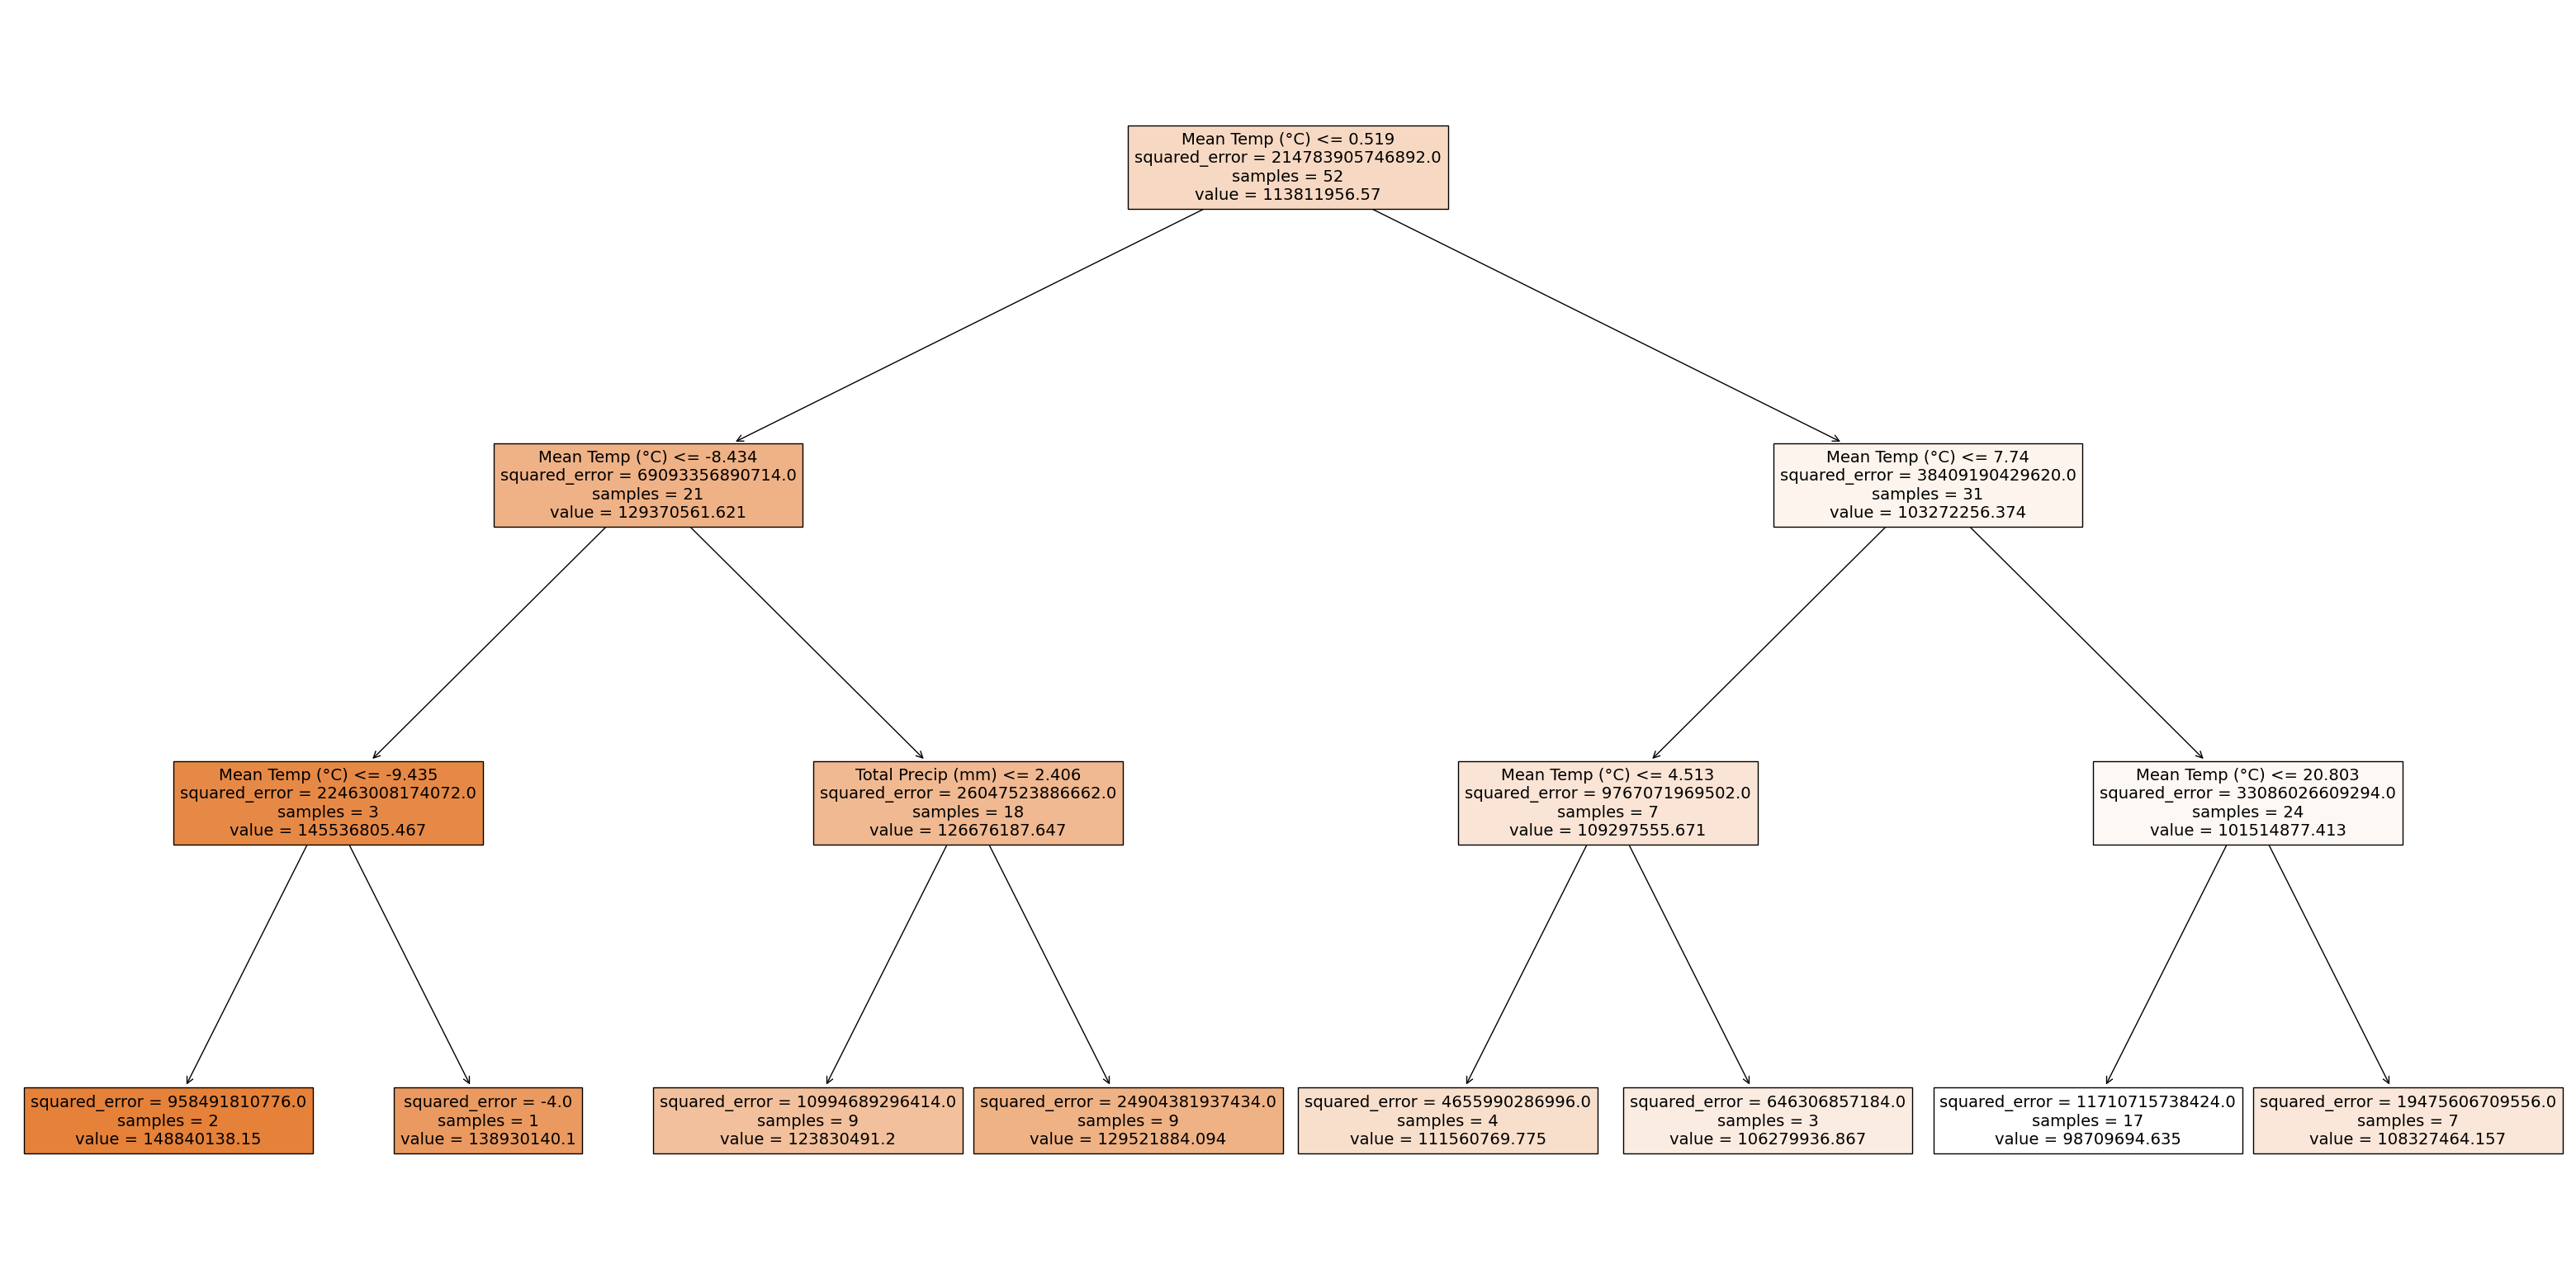

In [51]:
X = df_COMMERCIAL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_COMMERCIAL['Total (kWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_COMMERCIAL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_COMMERCIAL_normalized = rmse_COMMERCIAL / mean_COMMERCIAL
print("Root Mean Squared Error Normalized:", rmse_COMMERCIAL_normalized)

mae_COMMERCIAL = mean_absolute_error(y_test, y_pred)
mae_COMMERCIAL_normalized = mae_COMMERCIAL / mean_COMMERCIAL
print("Mean Absolute Error Normalized:", mae_COMMERCIAL_normalized)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()

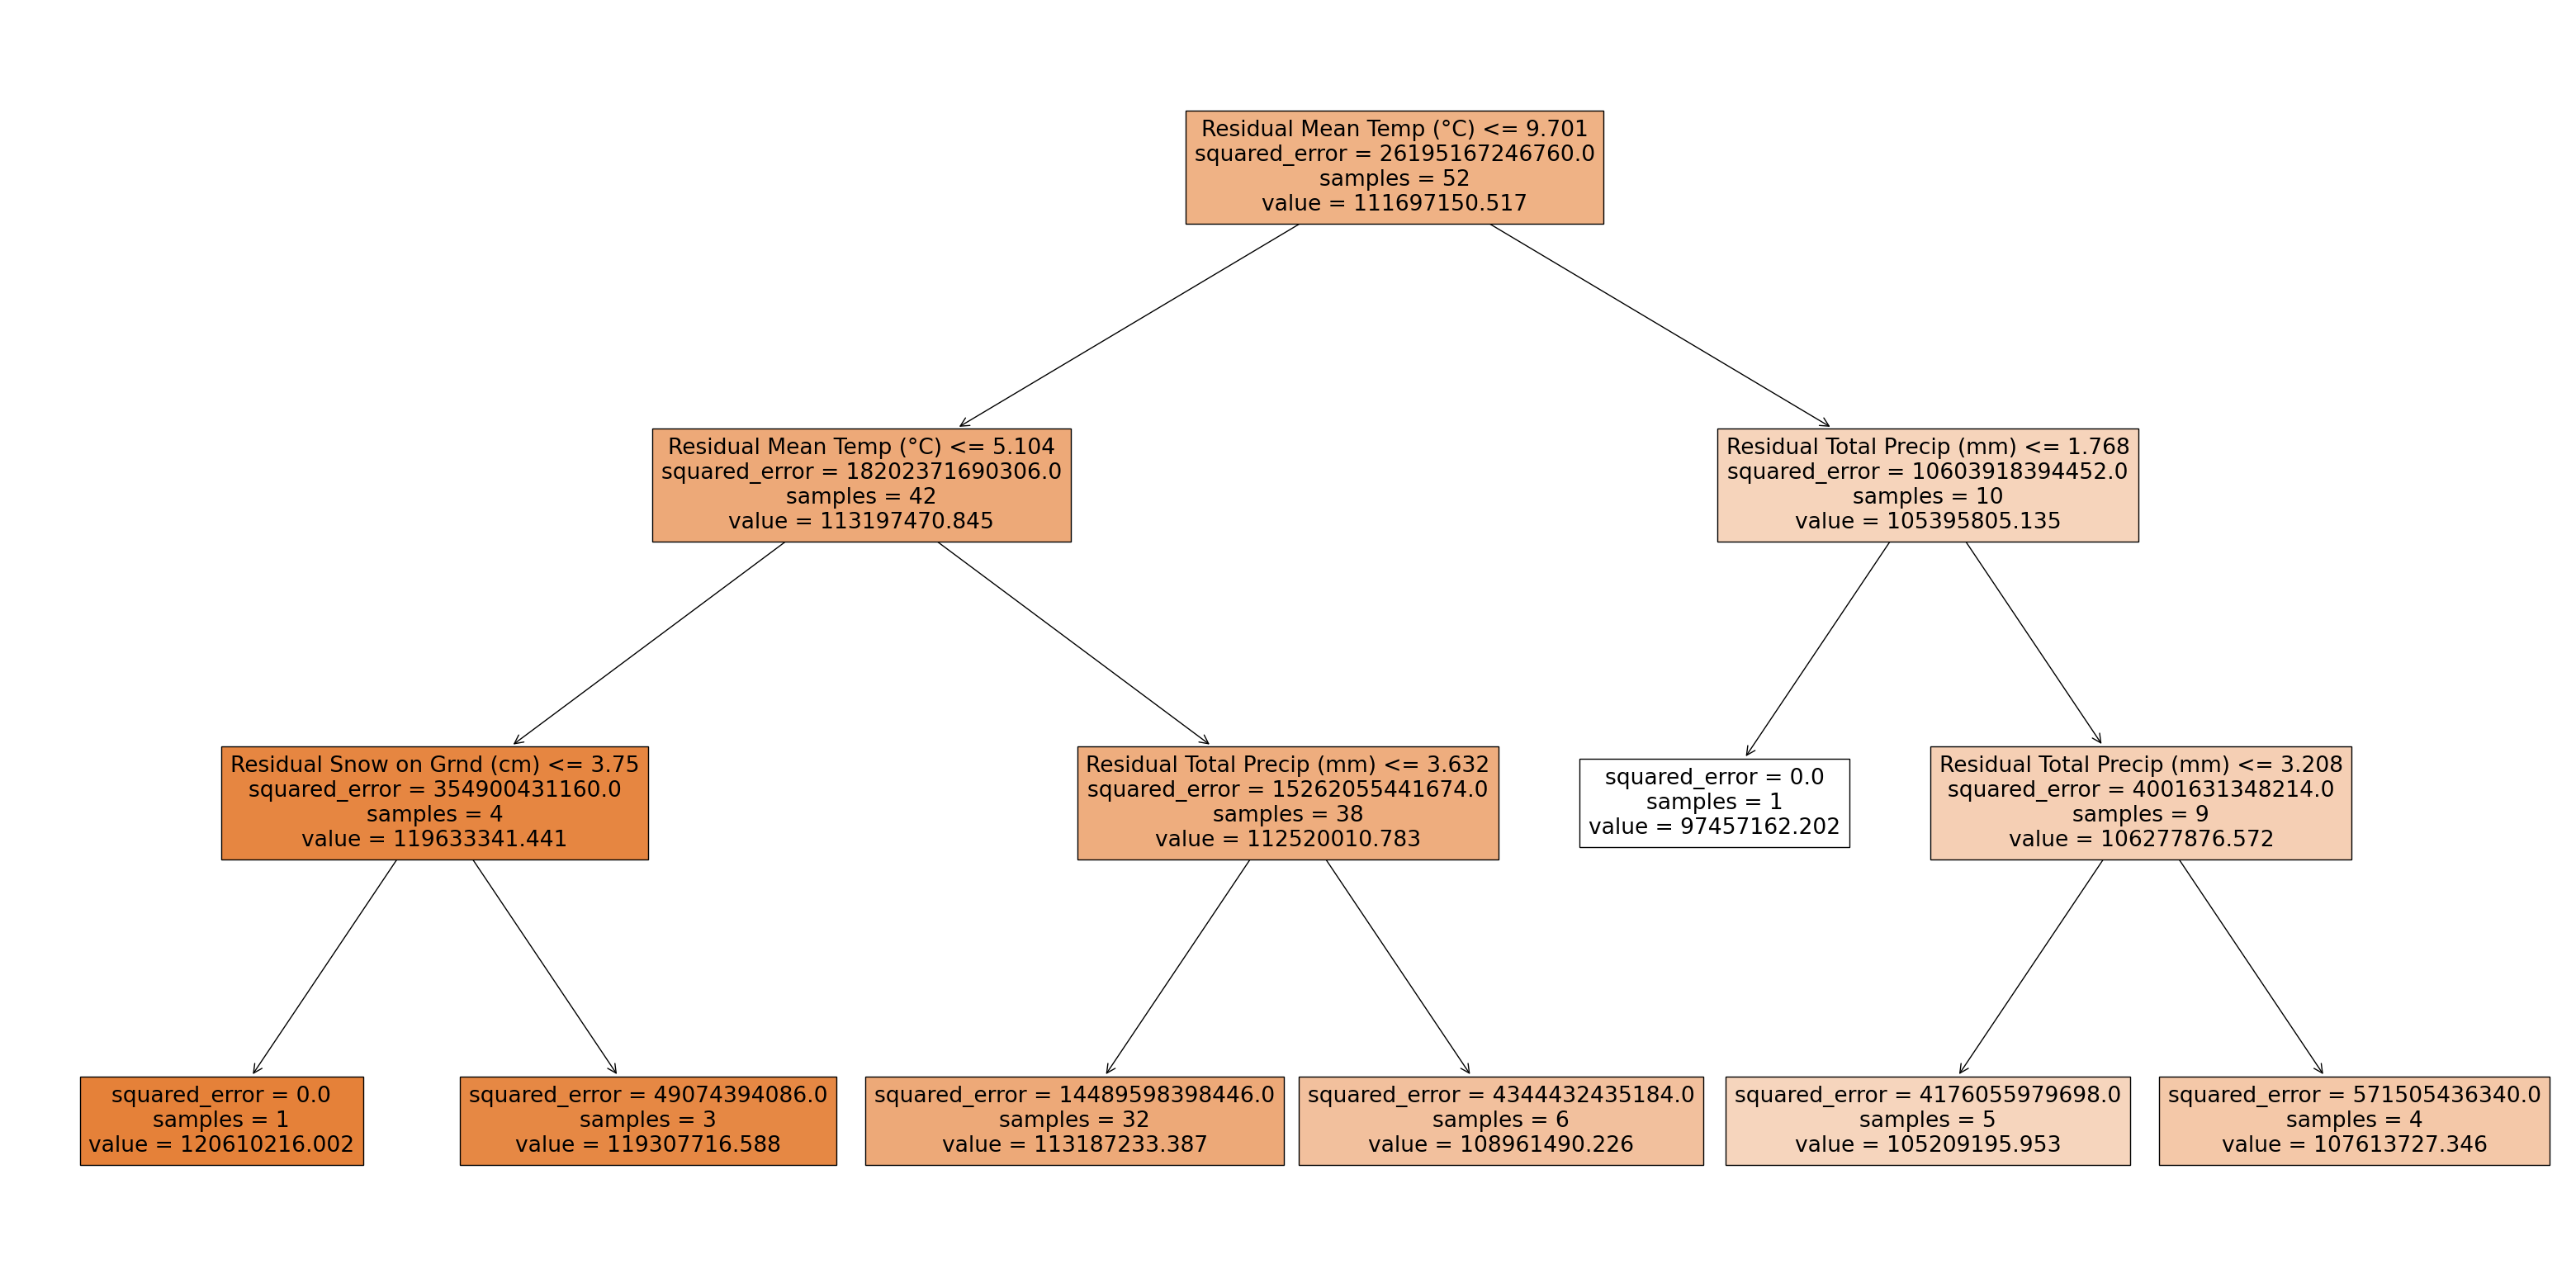

In [52]:
X = df_COMMERCIAL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_COMMERCIAL['Residual']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()

In [53]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_COMMERCIAL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_COMMERCIAL['Residual']
    match_index = df_COMMERCIAL.index[df_COMMERCIAL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_COMMERCIAL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_COMMERCIAL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_COMMERCIAL_normalized = rmse_COMMERCIAL / mean_COMMERCIAL
print("Root Mean Squared Error Normalized:", rmse_COMMERCIAL_normalized)

mae_COMMERCIAL = mean_absolute_error(y_test, y_pred)
mae_COMMERCIAL_normalized = mae_COMMERCIAL / mean_COMMERCIAL
print("Mean Absolute Error Normalized:", mae_COMMERCIAL_normalized)

R² score on test set: 0.858685186672561
Root Mean Squared Error Normalized: 0.048929930908756046
Mean Absolute Error Normalized: 0.0412417427333627


INDUSTRIEL

R² score on test set: -0.2569911142889527
Root Mean Squared Error Normalized: 0.08736293743090423
Mean Absolute Error Normalized: 0.06964869433689327


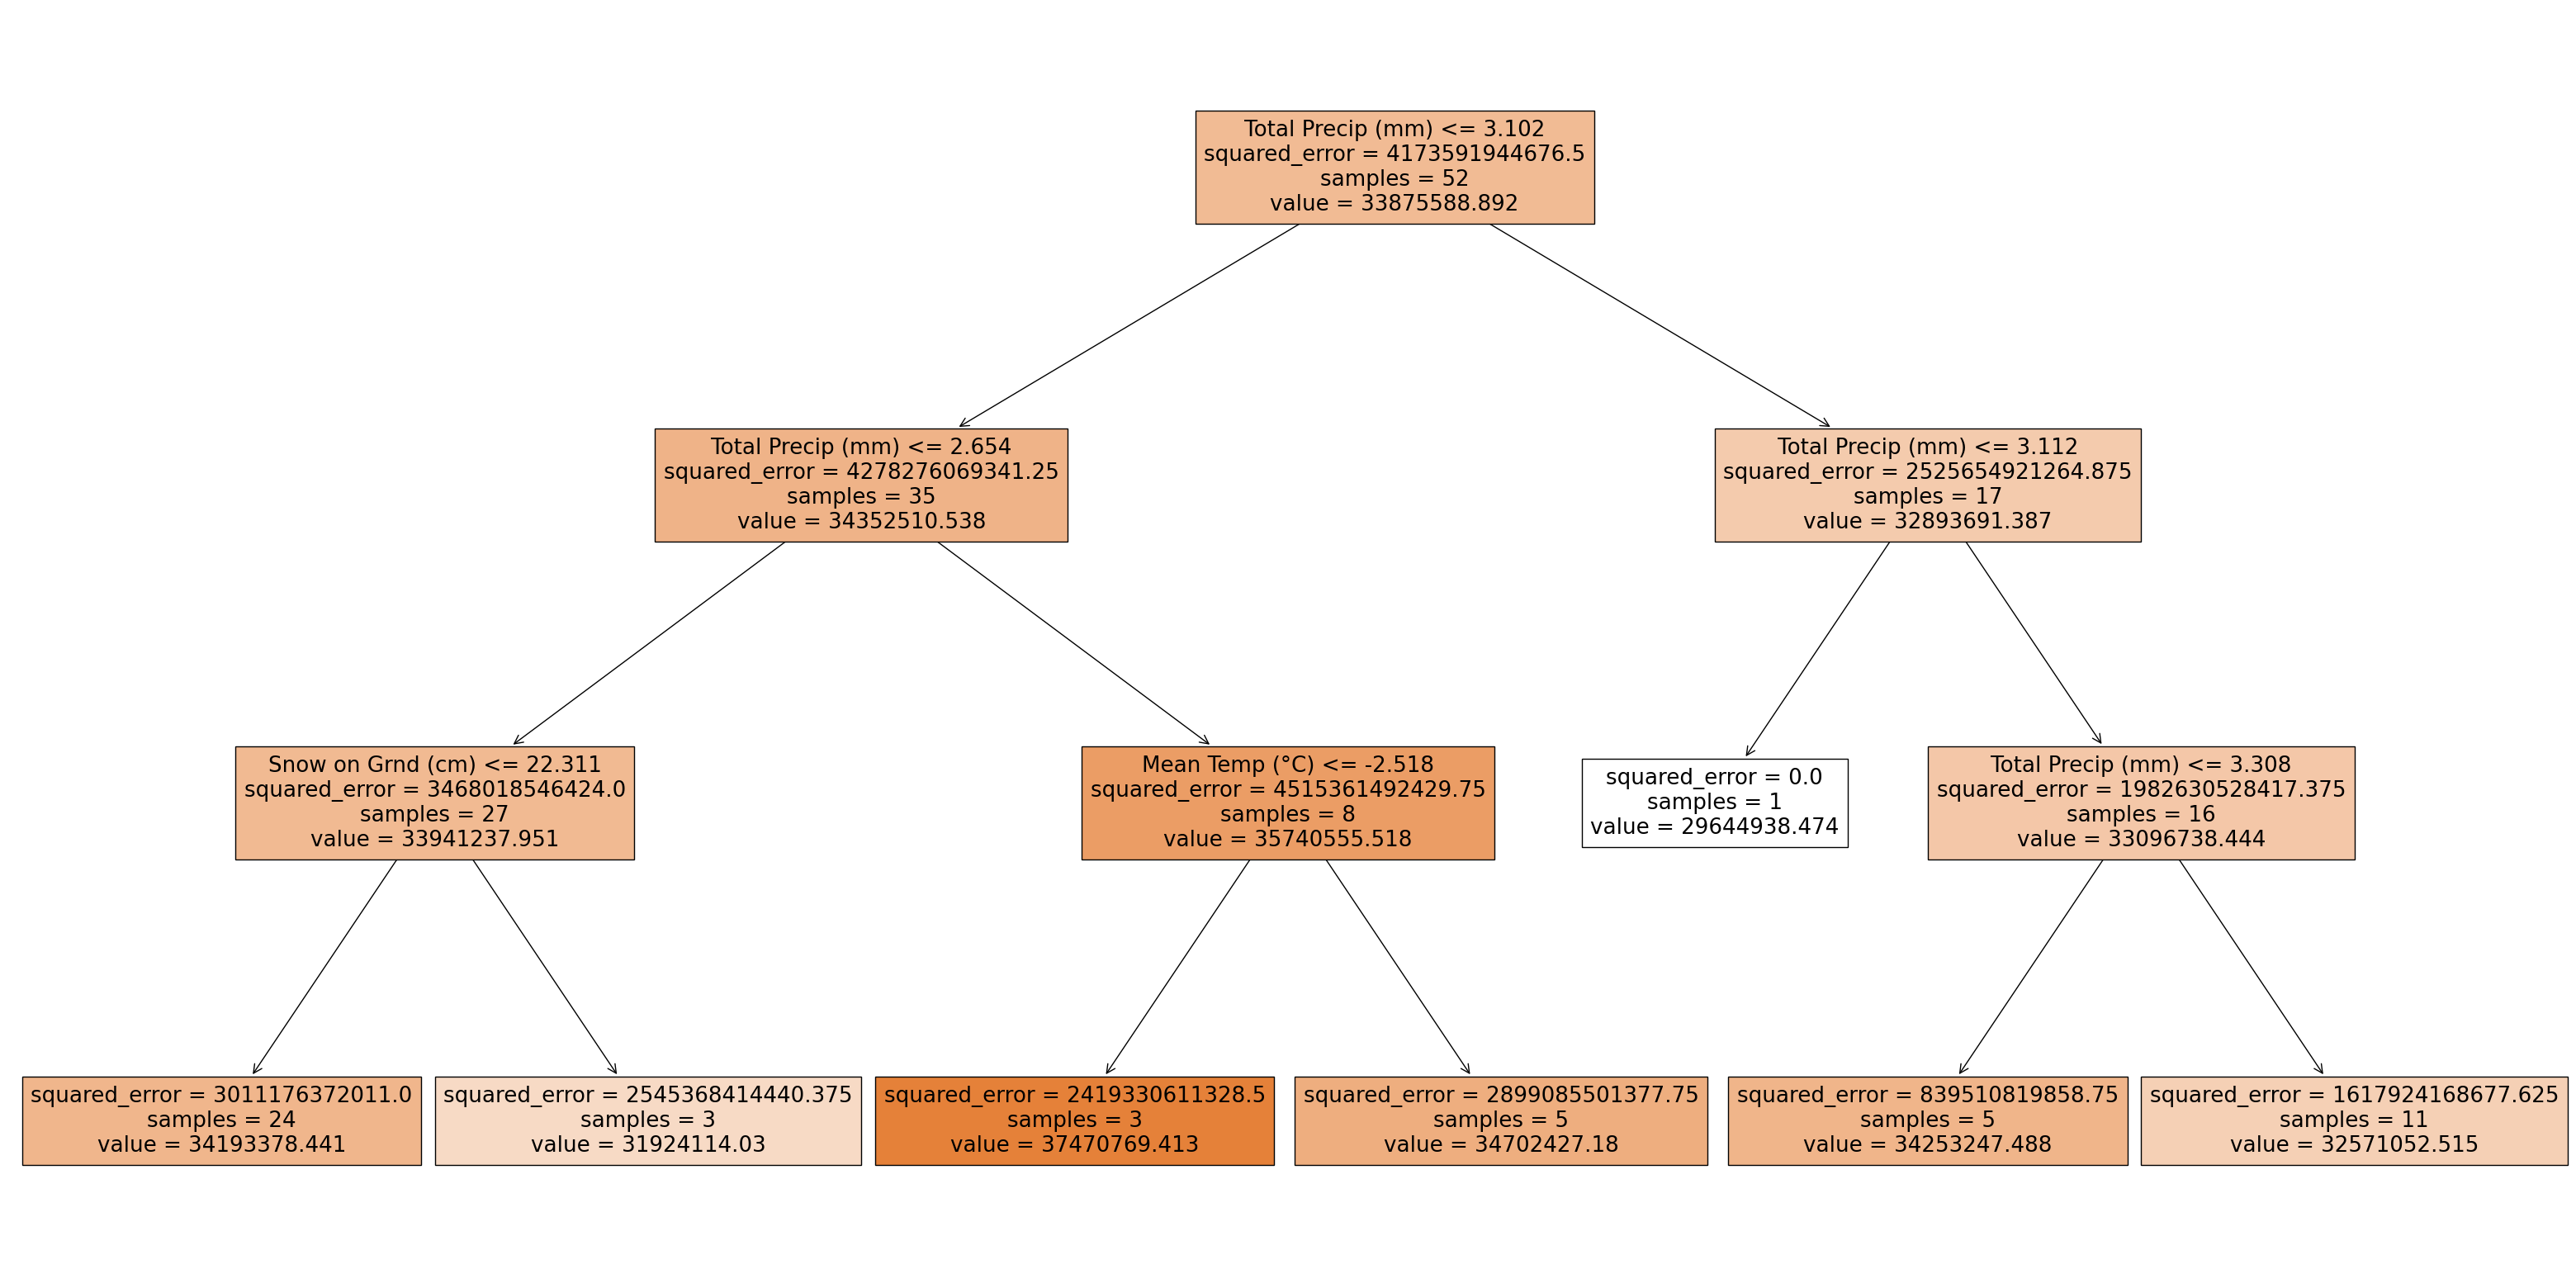

In [54]:
X = df_INDUSTRIEL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_INDUSTRIEL['Total (kWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_INDUSTRIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INDUSTRIEL_normalized = rmse_INDUSTRIEL/mean_INDUSTRIEL
print("Root Mean Squared Error Normalized:", rmse_INDUSTRIEL_normalized)

mae_INDUSTRIEL = mean_absolute_error(y_test, y_pred)
mae_INDUSTRIEL_normalized = mae_INDUSTRIEL / mean_INDUSTRIEL
print("Mean Absolute Error Normalized:", mae_INDUSTRIEL_normalized)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()

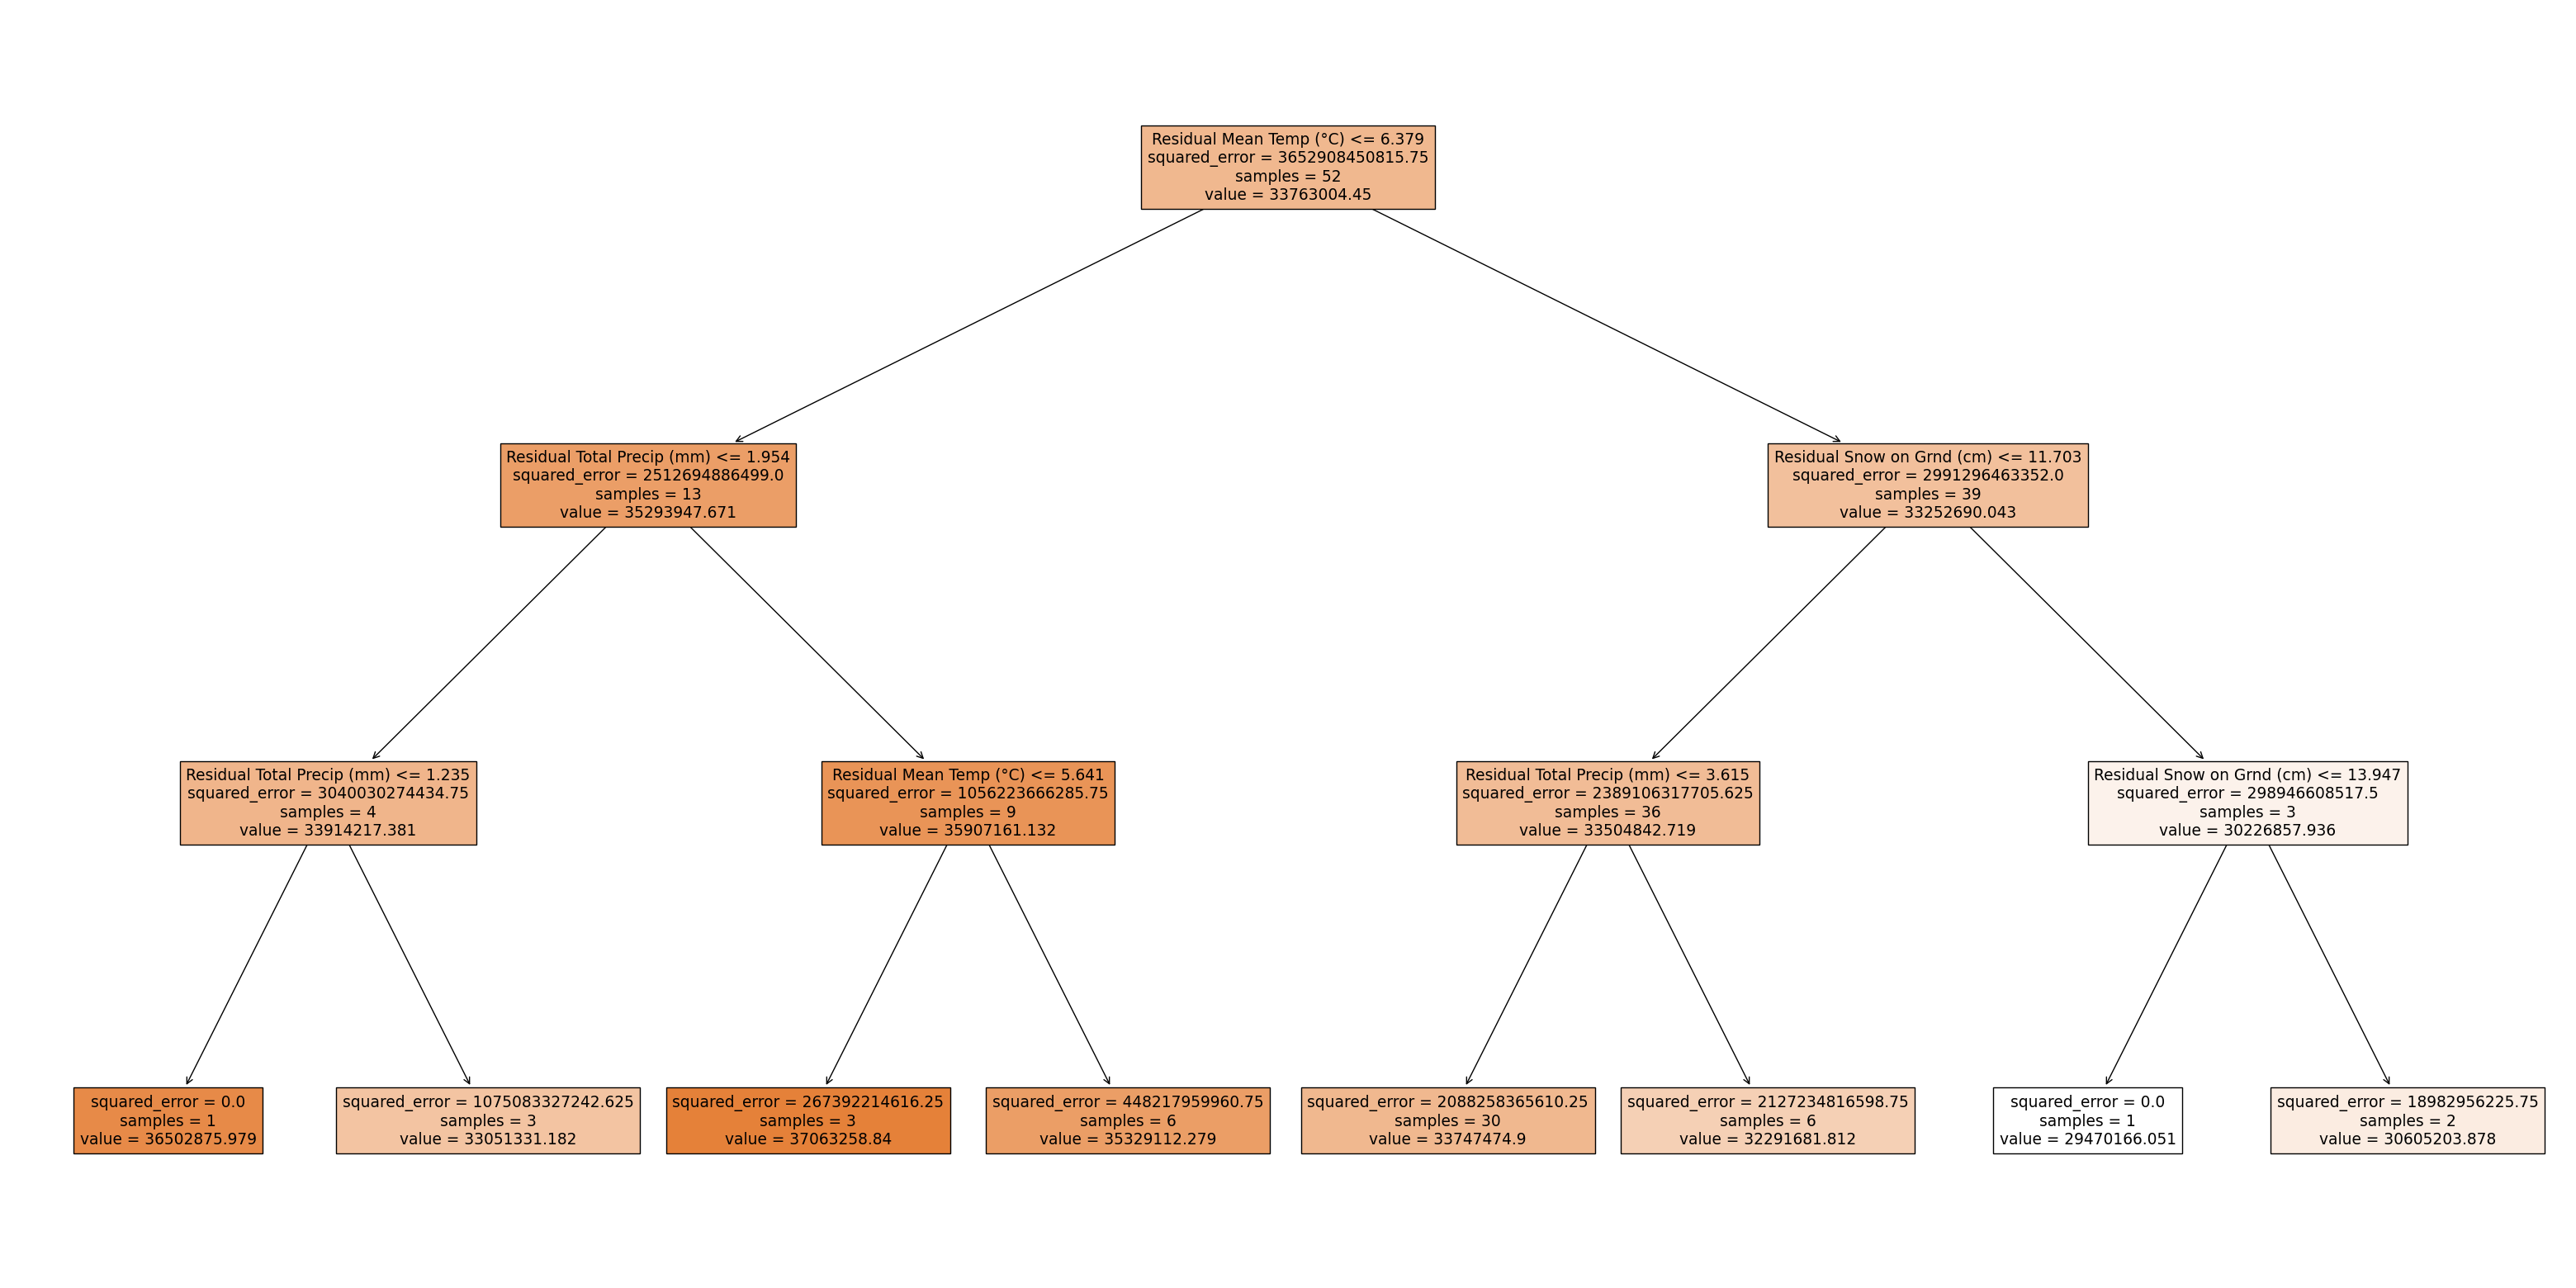

In [55]:
X = df_INDUSTRIEL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_INDUSTRIEL['Residual']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()


In [56]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_INDUSTRIEL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_INDUSTRIEL['Residual']
    match_index = df_INDUSTRIEL.index[df_INDUSTRIEL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_INDUSTRIEL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_INDUSTRIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INDUSTRIEL_normalized = rmse_INDUSTRIEL / mean_INDUSTRIEL
print("Root Mean Squared Error Normalized:", rmse_INDUSTRIEL_normalized)

mae_INDUSTRIEL = mean_absolute_error(y_test, y_pred)
mae_INDUSTRIEL_normalized = mae_INDUSTRIEL / mean_INDUSTRIEL
print("Mean Absolute Error Normalized:", mae_INDUSTRIEL_normalized)

R² score on test set: 0.17971681461933164
Root Mean Squared Error Normalized: 0.07057372304660688
Mean Absolute Error Normalized: 0.06113688055071712


RÉSIDENTIEL

R² score on test set: 0.9609179917363625
Root Mean Squared Error Normalized: 0.07695926359267041
Mean Absolute Error Normalized: 0.06430834770600045


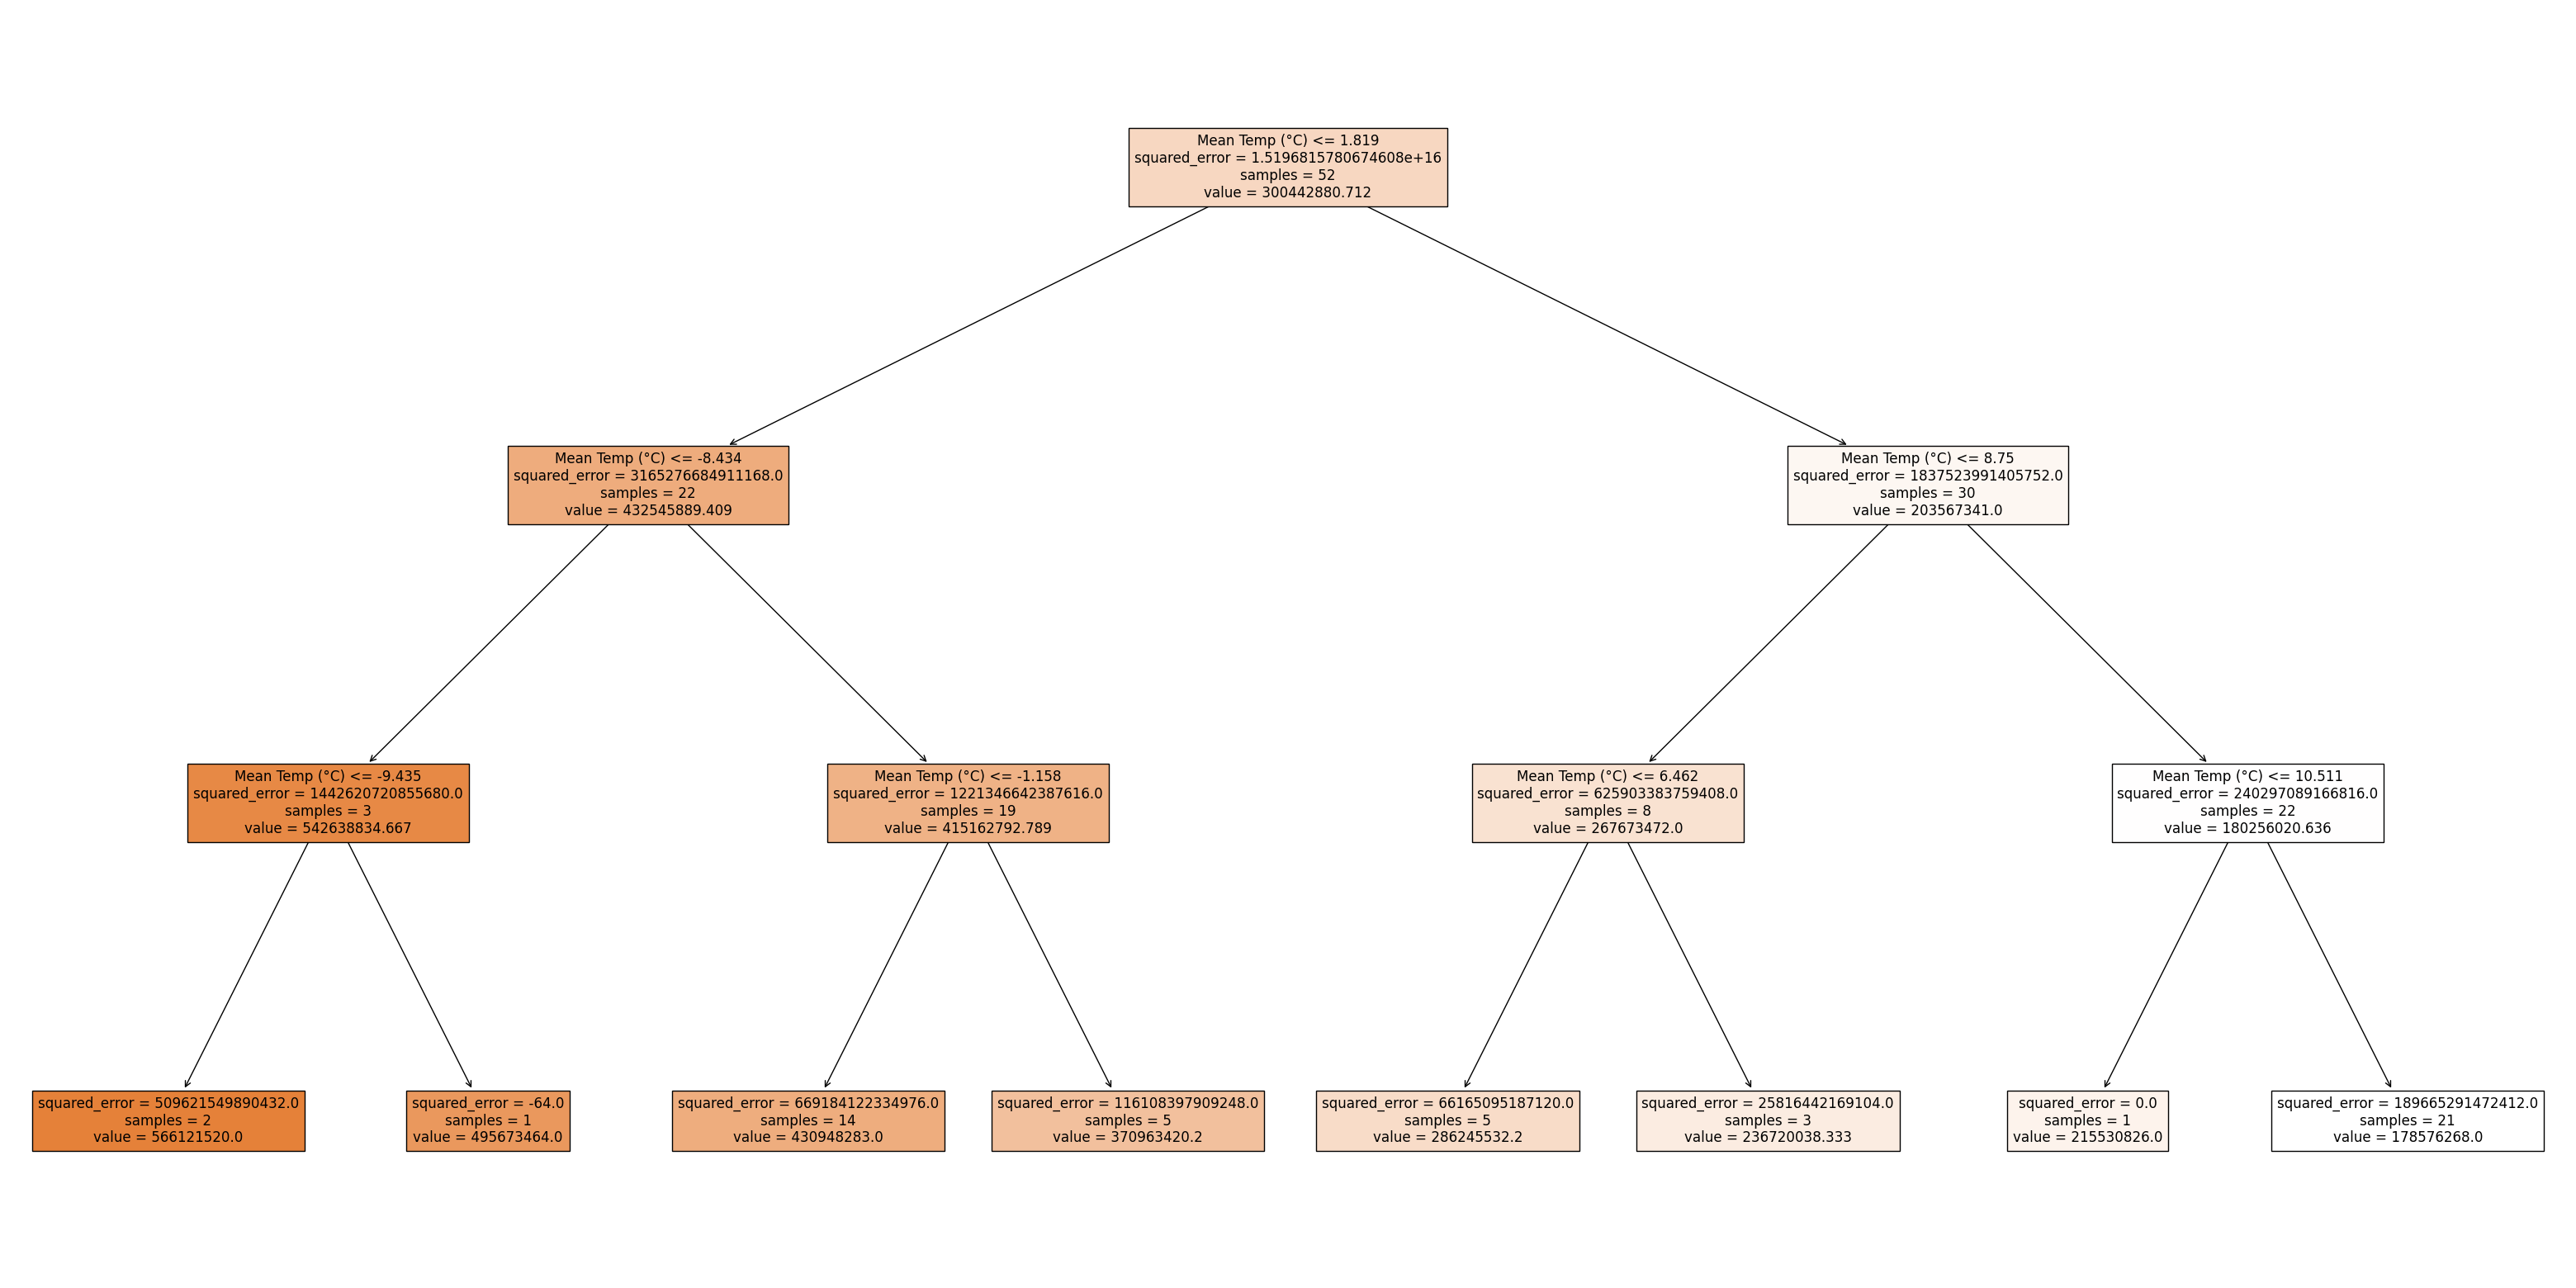

In [57]:
X = df_RÉSIDENTIEL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_RÉSIDENTIEL['Total (kWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_RÉSIDENTIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_RÉSIDENTIEL_normalized = rmse_RÉSIDENTIEL / mean_RÉSIDENTIEL
print("Root Mean Squared Error Normalized:", rmse_RÉSIDENTIEL_normalized)

mae_RÉSIDENTIEL = mean_absolute_error(y_test, y_pred)
mae_RÉSIDENTIEL_normalized = mae_RÉSIDENTIEL / mean_RÉSIDENTIEL
print("Mean Absolute Error Normalized:", mae_RÉSIDENTIEL_normalized)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()

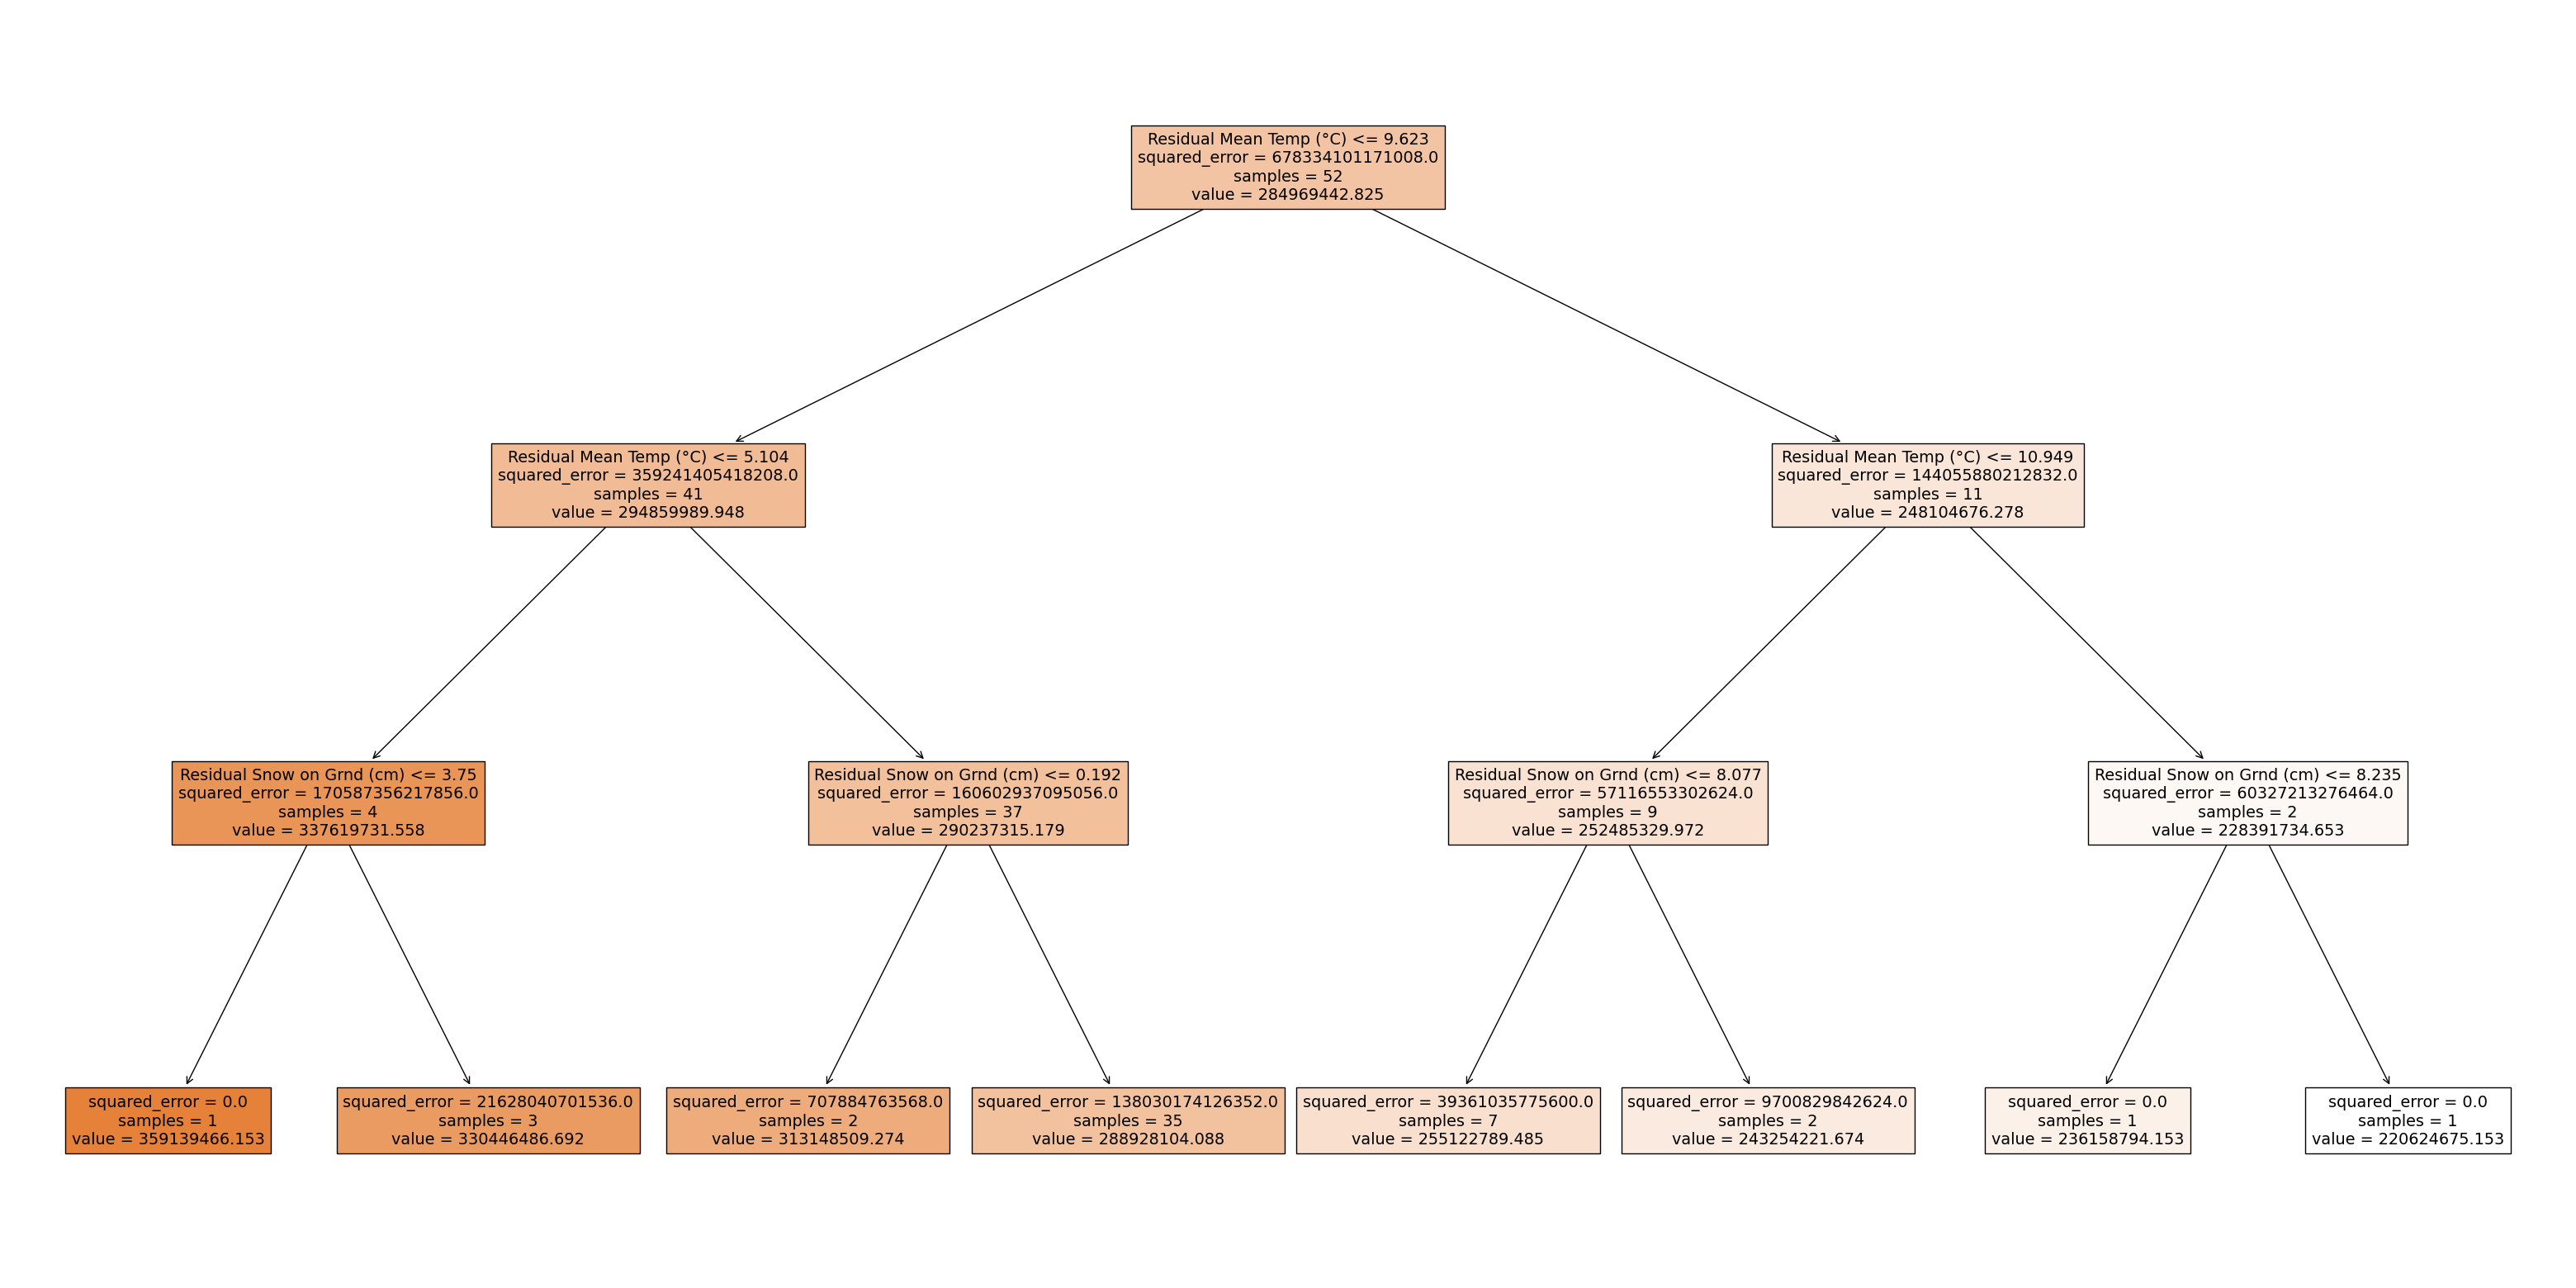

In [58]:
X = df_RÉSIDENTIEL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_RÉSIDENTIEL['Residual']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regressor = DecisionTreeRegressor(random_state=42, max_depth=3)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.show()


In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_RÉSIDENTIEL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_RÉSIDENTIEL['Residual']
    match_index = df_RÉSIDENTIEL.index[df_RÉSIDENTIEL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_RÉSIDENTIEL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_RÉSIDENTIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_RÉSIDENTIEL_normalized = rmse_RÉSIDENTIEL/mean_RÉSIDENTIEL
print("Root Mean Squared Error Normalized:", rmse_RÉSIDENTIEL_normalized)

mae_RÉSIDENTIEL = mean_absolute_error(y_test, y_pred)
mae_RÉSIDENTIEL_normalized = mae_RÉSIDENTIEL / mean_RÉSIDENTIEL
print("Mean Absolute Error Normalized:", mae_RÉSIDENTIEL_normalized)

R² score on test set: 0.9848258154016037
Root Mean Squared Error Normalized: 0.0479540342142512
Mean Absolute Error Normalized: 0.03320402312371094


# section Regression

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
#to have the std-coef
import statsmodels.api as sm
from scipy.stats.mstats import zscore

In [81]:
# Define features (X) and target variable (y)
X = df_RÉSIDENTIEL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_RÉSIDENTIEL['Total (kWh)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_RÉSIDENTIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_RÉSIDENTIEL_normalized = rmse_RÉSIDENTIEL/mean_RÉSIDENTIEL
print("Root Mean Squared Error Normalized:", rmse_RÉSIDENTIEL_normalized)

mae_RÉSIDENTIEL = mean_absolute_error(y_test, y_pred)
mae_RÉSIDENTIEL_normalized = mae_RÉSIDENTIEL / mean_RÉSIDENTIEL
print("Mean Absolute Error Normalized:", mae_RÉSIDENTIEL_normalized)

coefficients = regressor.coef_
intercept = regressor.intercept_

# Print the equation
equation = f'y = {intercept}'
for i, coef in enumerate(coefficients):
    equation += f' + {coef:.2f} * X{[i+1]}'
print("Linear Regression Equation:", equation)

R² score on test set: 0.8495191987182693
Root Mean Squared Error Normalized: 0.15101254084612198
Mean Absolute Error Normalized: 0.13231139011500692
Linear Regression Equation: y = 383196244.21434677 + -9942254.95 * X[1] + -7427258.87 * X[2] + 903265.44 * X[3]


In [80]:
#To note that this fonction doesn't separate the dataset btw test and train but take it as a all that's why the result may differ
print(sm.OLS(zscore(y), zscore(X)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:            Total (kWh)   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                              210.5
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    1.49e-35
Time:                        17:45:49   Log-Likelihood:                         -20.936
No. Observations:                  75   AIC:                                      47.87
Df Residuals:                      72   BIC:                                      54.83
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [64]:
# Define features (X) and target variable (y)
X = df_RÉSIDENTIEL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_RÉSIDENTIEL['Residual']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


print(sm.OLS(zscore(y), zscore(X)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Residual   R-squared (uncentered):                   0.678
Model:                            OLS   Adj. R-squared (uncentered):              0.665
Method:                 Least Squares   F-statistic:                              50.62
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    1.04e-17
Time:                        17:26:03   Log-Likelihood:                         -63.880
No. Observations:                  75   AIC:                                      133.8
Df Residuals:                      72   BIC:                                      140.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [65]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_RÉSIDENTIEL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_RÉSIDENTIEL['Residual']
    match_index = df_RÉSIDENTIEL.index[df_RÉSIDENTIEL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_RÉSIDENTIEL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_RÉSIDENTIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_RÉSIDENTIEL_normalized = rmse_RÉSIDENTIEL/mean_RÉSIDENTIEL
print("Root Mean Squared Error Normalized:", rmse_RÉSIDENTIEL_normalized)

mae_RÉSIDENTIEL = mean_absolute_error(y_test, y_pred)
mae_RÉSIDENTIEL_normalized = mae_RÉSIDENTIEL / mean_RÉSIDENTIEL
print("Mean Absolute Error Normalized:", mae_RÉSIDENTIEL_normalized)

R² score on test set: 0.9819081965721945
Root Mean Squared Error Normalized: 0.05236165892632764
Mean Absolute Error Normalized: 0.041819140557356645


In [67]:
# Define features (X) and target variable (y)
X = df_AGRICOLE[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_AGRICOLE['Total (kWh)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_AGRICOLE = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_AGRICOLE_normalized = rmse_AGRICOLE / mean_AGRICOLE
print("Root Mean Squared Error Normalized:", rmse_AGRICOLE_normalized)

mae_AGRICOLE = mean_absolute_error(y_test, y_pred)
mae_AGRICOLE_normalized = mae_AGRICOLE / mean_AGRICOLE
print("Mean Absolute Error Normalized:", mae_AGRICOLE_normalized)

print(sm.OLS(zscore(y), zscore(X)).fit().summary())

R² score on test set: 0.040965886120714834
Root Mean Squared Error Normalized: 0.14003088216615495
Mean Absolute Error Normalized: 0.11598613293714825
                                 OLS Regression Results                                
Dep. Variable:            Total (kWh)   R-squared (uncentered):                   0.364
Model:                            OLS   Adj. R-squared (uncentered):              0.337
Method:                 Least Squares   F-statistic:                              13.71
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    3.65e-07
Time:                        17:28:48   Log-Likelihood:                         -89.479
No. Observations:                  75   AIC:                                      185.0
Df Residuals:                      72   BIC:                                      191.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                    

In [68]:
# Define features (X) and target variable (y)
X = df_AGRICOLE[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_AGRICOLE['Residual']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(sm.OLS(zscore(y), zscore(X)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Residual   R-squared (uncentered):                   0.142
Model:                            OLS   Adj. R-squared (uncentered):              0.106
Method:                 Least Squares   F-statistic:                              3.976
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                      0.0111
Time:                        17:31:08   Log-Likelihood:                         -100.67
No. Observations:                  75   AIC:                                      207.3
Df Residuals:                      72   BIC:                                      214.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [69]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_AGRICOLE['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_AGRICOLE['Residual']
    match_index = df_AGRICOLE.index[df_AGRICOLE['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_AGRICOLE.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_AGRICOLE = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_AGRICOLE_normalized = rmse_AGRICOLE / mean_AGRICOLE
print("Root Mean Squared Error Normalized:", rmse_AGRICOLE_normalized)

mae_AGRICOLE = mean_absolute_error(y_test, y_pred)
mae_AGRICOLE_normalized = mae_AGRICOLE / mean_AGRICOLE
print("Mean Absolute Error Normalized:", mae_AGRICOLE_normalized)

R² score on test set: 0.6074341431944403
Root Mean Squared Error Normalized: 0.0895907266558566
Mean Absolute Error Normalized: 0.0710259414360603


In [70]:
# Define features (X) and target variable (y)
X = df_COMMERCIAL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_COMMERCIAL['Total (kWh)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_COMMERCIAL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_COMMERCIAL_normalized = rmse_COMMERCIAL / mean_COMMERCIAL
print("Root Mean Squared Error Normalized:", rmse_COMMERCIAL_normalized)

mae_COMMERCIAL = mean_absolute_error(y_test, y_pred)
mae_COMMERCIAL_normalized = mae_COMMERCIAL / mean_COMMERCIAL
print("Mean Absolute Error Normalized:", mae_COMMERCIAL_normalized)

print(sm.OLS(zscore(y), zscore(X)).fit().summary())

R² score on test set: 0.4655340613815694
Root Mean Squared Error Normalized: 0.09515700717891148
Mean Absolute Error Normalized: 0.07443520048202404
                                 OLS Regression Results                                
Dep. Variable:            Total (kWh)   R-squared (uncentered):                   0.639
Model:                            OLS   Adj. R-squared (uncentered):              0.624
Method:                 Least Squares   F-statistic:                              42.48
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    6.48e-16
Time:                        17:31:28   Log-Likelihood:                         -68.214
No. Observations:                  75   AIC:                                      142.4
Df Residuals:                      72   BIC:                                      149.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                      

In [71]:
# Define features (X) and target variable (y)
X = df_COMMERCIAL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_COMMERCIAL['Residual']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(sm.OLS(zscore(y), zscore(X)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Residual   R-squared (uncentered):                   0.259
Model:                            OLS   Adj. R-squared (uncentered):              0.228
Method:                 Least Squares   F-statistic:                              8.382
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    7.48e-05
Time:                        17:31:46   Log-Likelihood:                         -95.187
No. Observations:                  75   AIC:                                      196.4
Df Residuals:                      72   BIC:                                      203.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_COMMERCIAL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_COMMERCIAL['Residual']
    match_index = df_COMMERCIAL.index[df_COMMERCIAL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_COMMERCIAL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_COMMERCIAL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_COMMERCIAL_normalized = rmse_COMMERCIAL / mean_COMMERCIAL
print("Root Mean Squared Error Normalized:", rmse_COMMERCIAL_normalized)

mae_COMMERCIAL = mean_absolute_error(y_test, y_pred)
mae_COMMERCIAL_normalized = mae_COMMERCIAL / mean_COMMERCIAL
print("Mean Absolute Error Normalized:", mae_COMMERCIAL_normalized)

R² score on test set: 0.8725184491461151
Root Mean Squared Error Normalized: 0.046473397895941515
Mean Absolute Error Normalized: 0.037348176034746945


In [72]:
# Define features (X) and target variable (y)
X = df_INDUSTRIEL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_INDUSTRIEL['Total (kWh)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_INDUSTRIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INDUSTRIEL_normalized = rmse_INDUSTRIEL / mean_INDUSTRIEL
print("Root Mean Squared Error Normalized:", rmse_INDUSTRIEL_normalized)

mae_INDUSTRIEL = mean_absolute_error(y_test, y_pred)
mae_INDUSTRIEL_normalized = mae_INDUSTRIEL / mean_INDUSTRIEL
print("Mean Absolute Error Normalized:", mae_INDUSTRIEL_normalized)

print(sm.OLS(zscore(y), zscore(X)).fit().summary())

R² score on test set: -0.10321025934799177
Root Mean Squared Error Normalized: 0.08184464516282124
Mean Absolute Error Normalized: 0.0687878897943663
                                 OLS Regression Results                                
Dep. Variable:            Total (kWh)   R-squared (uncentered):                   0.052
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              1.316
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                       0.276
Time:                        17:32:25   Log-Likelihood:                         -104.42
No. Observations:                  75   AIC:                                      214.8
Df Residuals:                      72   BIC:                                      221.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                     

In [73]:
# Define features (X) and target variable (y)
X = df_INDUSTRIEL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_INDUSTRIEL['Residual']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(sm.OLS(zscore(y), zscore(X)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Residual   R-squared (uncentered):                   0.121
Model:                            OLS   Adj. R-squared (uncentered):              0.085
Method:                 Least Squares   F-statistic:                              3.308
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                      0.0249
Time:                        17:32:39   Log-Likelihood:                         -101.58
No. Observations:                  75   AIC:                                      209.2
Df Residuals:                      72   BIC:                                      216.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_INDUSTRIEL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_INDUSTRIEL['Residual']
    match_index = df_INDUSTRIEL.index[df_INDUSTRIEL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_INDUSTRIEL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_INDUSTRIEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INDUSTRIEL_normalized = rmse_INDUSTRIEL / mean_INDUSTRIEL
print("Root Mean Squared Error Normalized:", rmse_INDUSTRIEL_normalized)

mae_INDUSTRIEL = mean_absolute_error(y_test, y_pred)
mae_INDUSTRIEL_normalized = mae_INDUSTRIEL / mean_INDUSTRIEL
print("Mean Absolute Error Normalized:", mae_INDUSTRIEL_normalized)

R² score on test set: 0.0823764032367138
Root Mean Squared Error Normalized: 0.07464374330115299
Mean Absolute Error Normalized: 0.059881112609052774


In [74]:
# Define features (X) and target variable (y)
X = df_INSTITUTIONNEL[['Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
y = df_INSTITUTIONNEL['Total (kWh)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("R² score on test set:", r2_test)

rmse_INSTITUTIONNEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INSTITUTIONNEL_normalized = rmse_INSTITUTIONNEL / mean_INSTITUTIONNEL
print("Root Mean Squared Error Normalized:", rmse_INSTITUTIONNEL_normalized)

mae_INSTITUTIONNEL = mean_absolute_error(y_test, y_pred)
mae_INSTITUTIONNEL_normalized = mae_INSTITUTIONNEL / mean_INSTITUTIONNEL
print("Mean Absolute Error Normalized:", mae_INSTITUTIONNEL_normalized)

print(sm.OLS(zscore(y), zscore(X)).fit().summary())

R² score on test set: 0.8135784129700894
Root Mean Squared Error Normalized: 0.051361758774333945
Mean Absolute Error Normalized: 0.04096610801312352
                                 OLS Regression Results                                
Dep. Variable:            Total (kWh)   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              180.5
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    2.06e-33
Time:                        17:32:54   Log-Likelihood:                         -26.083
No. Observations:                  75   AIC:                                      58.17
Df Residuals:                      72   BIC:                                      65.12
Df Model:                           3                                                  
Covariance Type:            nonrobust                     

In [77]:
# Define features (X) and target variable (y)
X = df_INSTITUTIONNEL[['Residual Mean Temp (°C)', 'Residual Total Precip (mm)', 'Residual Snow on Grnd (cm)']]
y = df_INSTITUTIONNEL['Residual']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print(sm.OLS(zscore(y), zscore(X)).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Residual   R-squared (uncentered):                   0.374
Model:                            OLS   Adj. R-squared (uncentered):              0.348
Method:                 Least Squares   F-statistic:                              14.34
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    2.03e-07
Time:                        17:33:15   Log-Likelihood:                         -88.855
No. Observations:                  75   AIC:                                      183.7
Df Residuals:                      72   BIC:                                      190.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_test_df = y_test.to_frame()

y_pred_df_reset_index = y_pred_df.reset_index(drop=True)
y_test_df_reset_index = y_test_df.reset_index(drop=True)

concatenated_df = pd.concat([y_test_df_reset_index, y_pred_df_reset_index], axis=1)

# Iterate over the rows of concatenated_df
for index, row in concatenated_df.iterrows():
    # Get the corresponding value from df_INSTITUTIONNEL['Residual']
    residual_value = row['Residual']

    # Find the index where the residual value matches in df_INSTITUTIONNEL['Residual']
    match_index = df_INSTITUTIONNEL.index[df_INSTITUTIONNEL['Residual'] == residual_value].tolist()

    # If a match is found, update the corresponding value in concatenated_df['seasonality']
    if match_index:
        concatenated_df.at[index, 'seasonality'] = df_INSTITUTIONNEL.at[match_index[0], 'Seasonality']

# Create the test_seasonality column
concatenated_df['test_seasonality'] = concatenated_df['Residual'] + concatenated_df['seasonality']

# Create the pred_seasonality column
concatenated_df['pred_seasonality'] = concatenated_df['y_pred'] + concatenated_df['seasonality']

r2_test = r2_score(concatenated_df['test_seasonality'], concatenated_df['pred_seasonality'])
print("R² score on test set:", r2_test)

rmse_INSTITUTIONNEL = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_INSTITUTIONNEL_normalized = rmse_INSTITUTIONNEL / mean_INSTITUTIONNEL
print("Root Mean Squared Error Normalized:", rmse_INSTITUTIONNEL_normalized)

mae_INSTITUTIONNEL = mean_absolute_error(y_test, y_pred)
mae_INSTITUTIONNEL_normalized = mae_INSTITUTIONNEL / mean_INSTITUTIONNEL
print("Mean Absolute Error Normalized:", mae_INSTITUTIONNEL_normalized)

R² score on test set: 0.9297475041279415
Root Mean Squared Error Normalized: 0.0315299052334526
Mean Absolute Error Normalized: 0.02603504350719851
